In [1]:
import datetime  
import numpy as np  
import pandas as pd
import numpy.random as random
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf
import time
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from math import sqrt
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.style.use('seaborn-whitegrid')
import os
#os.environ[‘CC’] = ‘gcc-10’
#os.environ[‘CXX’] = ‘g++-10’

In [2]:
import pystan
import multiprocessing
multiprocessing.set_start_method("fork")

In [3]:
print (pystan.__version__)

2.19.1.1


In [4]:
###  Some Helper functions


#regex to find columns with desired string in name
def columns_subset(col_list, string):

    reg = re.compile(string)
    subset_cols =list(filter(reg.match, col_list))
#     print str(subset_cols)
#     print "\nThis selects for ",len(subset_cols), " out of ",len(col_list),"columns"
    return subset_cols
#  Example 
#d=columns_subset(MMM_Mod_Scale.columns, '.*\\_M_TV')

# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

# 2. Model Implementation
# The model is built in a stacked way. Three models are trained:   
# - Control Model
# - Marketing Mix Model
# 2.1 Control Model / Base Sales Model
#import pystan
import os
#os.environ['CC'] = 'gcc-10'
#os.environ['CXX'] = 'g++-10'

# helper functions

###############################################
##. ADStock Transform Parameters & Function####
###############################################

AdStock_params = {
    
##   Media:  Decay, Peak, Length
  'M_DM'      : [0.5, 0, 6],  #'Direct mail'
  'M_EM'      : [0.1, 0, 2],  #'Email'
  'M_NP'      : [0.3, 0, 4],  #'Newspaper'
  'M_OD'      : [0.3, 0, 4],  #'Online display'
  'M_OH'      : [0.5, 1, 9],  #'Out of home' 
  'M_MG'      : [0.6, 1, 12], # 'Magazine'
  'M_SM'      : [0.3, 0, 3],  # 'Social Media'
  'M_PS'      : [0.1, 0, 2],  # 'Paid search'
  'M_TV'      : [0.7, 1, 10], # 'TV'
  'M_RD'      : [0.4, 0, 6],  # 'Radio'
  'M_CDL'     : [0.3, 0, 4],  # 'Cardlytics Data'
  'M_CN'      : [0.6, 1, 12], #  'Cinema'
   'M_AFF'    : [0.2, 0, 4]   #   'Affiliate' 
           
                 }


def apply_adstock(x,D, P, L):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    
    for l in range(L):
        weight =D**abs(l-P)
        weights[L-1-l] = weight
    adstocked_x = []
    for i in range(L-1, len(x)):
        
        x_array = x[i-L+1:i+1]
        
        xi = sum(x_array * weights)
        
        adstocked_x.append(xi)
#         adstocked_x = np.array(adstocked_x)
    return adstocked_x

AdStock_params = {
    
##   Media:  Decay, Peak, Length
  'M_DM'      : [0.5, 0, 6],  #'Direct mail'
  'M_EM'      : [0.1, 0, 2],  #'Email'
  'M_NP'      : [0.3, 0, 4],  #'Newspaper'
  'M_OD'      : [0.3, 0, 4],  #'Online display'
  'M_OH'      : [0.5, 1, 9],  #'Out of home' 
  'M_MG'      : [0.6, 1, 12], # 'Magazine'
  'M_SM'      : [0.3, 0, 3],  # 'Social Media'
  'M_PS'      : [0.1, 0, 2],  # 'Paid search'
  'M_TV'      : [0.7, 1, 10], # 'TV'
  'M_RD'      : [0.4, 0, 6],  # 'Radio'
  'M_CDL'     : [0.3, 0, 4],  # 'Cardlytics Data'
  'M_CN'      : [0.6, 1, 12], #  'Cinema'
   'M_AFF'    : [0.2, 0, 4]   #   'Affiliate' 
           
                 }


def apply_adstock(x,D, P, L):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    
    for l in range(L):
        weight =D**abs(l-P)
        weights[L-1-l] = weight
    adstocked_x = []
    for i in range(L-1, len(x)):
        
        x_array = x[i-L+1:i+1]
        
        xi = sum(x_array * weights)
        
        adstocked_x.append(xi)
#         adstocked_x = np.array(adstocked_x)
    return adstocked_x


from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data


# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

#mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
#adstock_params = mmm['adstock_params']
#mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)

# Import Processed Data

In [76]:
MMM_Mod =  pd.read_csv("~/Project/MMM_Q12021/Data/MMM_Mod_Data_v3.csv",parse_dates=['Wk_Start_dt','Wk_End_dt','Mth_End_Dt'])


In [6]:
#MMM_Mod =  pd.read_csv("~/Project/MMM1/Data/MMM_Mod_Data_v2.csv",parse_dates=['Wk_Start_dt','Wk_End_dt','Mth_End_Dt']).fillna(0)


Media_Var= ['BBD_M_DM_AME_L_PRD_CIR', 'BBD_M_DM_DML_L_PRD_CIR', 'BBD_M_NP_L_PRD_CIR', 'BBD_M_OD_L_OGN_PRD_OTH_GM_IMP', 'BBD_M_OH_L_PRD_IMP', 'FIB_M_CDL_L_IMP', 'FIB_M_CDL_L_TRP', 'FIB_M_DM_AME_L_PRD_CIR', 'FIB_M_DM_DML_L_PRD_CIR', 'FIB_M_OD_L_OGN_PRD_OTH_GM_IMP', 'FIB_M_OH_L_PRD_IMP', 'FIB_M_RD_L_PRD_GM_GRP', 'FIB_M_RD_L_PRD_GM_IMP', 'FIB_M_RD_L_PRD_HM_GRP', 'FIB_M_RD_L_PRD_HM_IMP', 'FIB_M_TV_LN_L_PRD_GM_GRP', 'FIB_M_TV_LN_L_PRD_GM_IMP', 'FIB_M_TV_LN_L_PRD_HM_GRP', 'FIB_M_TV_LN_L_PRD_HM_IMP', 'MOB_M_CDL_L_IMP', 'MOB_M_CDL_L_TRP', 'MOB_M_DM_AME_L_PRD_CIR', 'MOB_M_DM_CIU_L_PRD_CIR', 'MOB_M_DM_DML_L_PRD_CIR', 'MOB_M_NP_L_PRD_CIR', 'MOB_M_OD_L_OGN_PRD_OTH_GM_IMP', 'MOB_M_OH_L_PRD_IMP', 'MOB_M_RD_L_PRD_GM_GRP', 'MOB_M_RD_L_PRD_GM_IMP', 'MOB_M_RD_L_PRD_HM_GRP', 'MOB_M_RD_L_PRD_HM_IMP', 'MOB_M_TV_LN_L_PRD_GM_GRP', 'MOB_M_TV_LN_L_PRD_GM_IMP', 'Replicated_M_DM_AME_L_BDL_CIR', 'Replicated_M_DM_CIU_L_BDL_CIR', 'Replicated_M_DM_DML_L_BDL_CIR', 'Replicated_M_NP_L_BRD_CIR', 'Replicated_M_OH_L_BRD_IMP', 'Replicated_M_RD_L_ITA_GM_GRP', 'Replicated_M_RD_L_ITA_GM_IMP', 'Replicated_M_RD_L_ITA_HM_GRP', 'Replicated_M_RD_L_ITA_HM_IMP', 'Replicated_M_TV_LN_L_ITA_GM_GRP', 'Replicated_M_TV_LN_L_ITA_GM_IMP', 'Replicated_M_TV_LN_L_ITA_HM_GRP', 'Replicated_M_TV_LN_L_ITA_HM_IMP', 'VID_M_CDL_L_IMP', 'VID_M_CDL_L_TRP', 'VID_M_DM_AME_L_PRD_CIR', 'VID_M_DM_CIU_L_PRD_CIR', 'VID_M_DM_DML_L_PRD_CIR', 'VID_M_NP_L_PRD_CIR', 'VID_M_OD_L_OGN_PRD_OTH_GM_IMP', 'VID_M_OH_L_PRD_IMP', 'VID_M_RD_L_PRD_GM_GRP', 'VID_M_RD_L_PRD_GM_IMP', 'VID_M_RD_L_PRD_HM_GRP', 'VID_M_RD_L_PRD_HM_IMP', 'VID_M_TV_LN_L_PRD_GM_GRP', 'VID_M_TV_LN_L_PRD_GM_IMP', 'VID_M_TV_LN_L_PRD_HM_GRP', 'VID_M_TV_LN_L_PRD_HM_IMP', 'BBD_M_DM_DML_N_PRD_CIR', 'BBD_M_EM_PRD_CIR', 'BBD_M_MG_PRD_CIR', 'BBD_M_NP_N_PRD_CIR', 'BBD_M_OD_N_OGN_PRD_OTH_GM_IMP', 'BBD_M_OD_OAD_PRD_OTH_GM_IMP', 'BBD_M_OD_OGN_PRD_OTH_GM_IMP', 'BBD_M_OD_OGN_PRD_PRF_GM_IMP', 'BBD_M_OD_OGN_PRD_UPF_GM_IMP', 'BBD_M_OD_OVD_PRD_OTH_GM_IMP', 'BBD_M_OD_OVD_PRD_PRF_GM_IMP', 'BBD_M_OD_OVD_PRD_UPF_GM_IMP', 'BBD_M_OD_PRD_HM_IMP', 'BBD_M_OH_N_PRD_IMP', 'BBD_M_PS_PRD_BND_CLK', 'BBD_M_PS_PRD_NBD_CLK', 'BBD_M_SM_FB_PRD_OTH_IMP', 'BBD_M_SM_FB_PRD_PRF_IMP', 'BBD_M_SM_OT_PRD_IMP', 'BBD_M_SM_ST_PRD_IMP', 'BBD_M_SM_TW_PRD_IMP', 'BBD_M_TV_AD_PRD_IMP', 'DTN_M_RD_BC_N_PRD_GRP', 'DTN_M_SM_TW_PRD_IMP', 'DTN_M_TV_LN_N_PRD_GM_GRP', 'DTN_M_TV_LN_N_PRD_HM_GRP', 'EXL_M_PS_PRD_BND_CLK', 'EXL_M_PS_PRD_NBD_CLK', 'EXL_M_SM_FB_PRD_OTH_IMP', 'FIB_M_CDL_N_IMP', 'FIB_M_CDL_N_TRP', 'FIB_M_CN_N_PRD_IMP', 'FIB_M_DM_DML_N_PRD_CIR', 'FIB_M_EM_PRD_CIR', 'FIB_M_MG_PRD_CIR', 'FIB_M_OD_N_OGN_PRD_OTH_GM_IMP', 'FIB_M_OD_OAD_PRD_OTH_GM_IMP', 'FIB_M_OD_OAD_PRD_PRF_GM_IMP', 'FIB_M_OD_OAD_PRD_UPF_GM_IMP', 'FIB_M_OD_OGN_PRD_OTH_GM_IMP', 'FIB_M_OD_OGN_PRD_PRF_GM_IMP', 'FIB_M_OD_OGN_PRD_UPF_GM_IMP', 'FIB_M_OD_OVD_PRD_OTH_GM_IMP', 'FIB_M_OD_OVD_PRD_PRF_GM_IMP', 'FIB_M_OD_OVD_PRD_UPF_GM_IMP', 'FIB_M_OD_PRD_HM_IMP', 'FIB_M_OH_N_PRD_IMP', 'FIB_M_PS_PRD_BND_CLK', 'FIB_M_PS_PRD_NBD_CLK', 'FIB_M_SM_FB_PRD_OTH_IMP', 'FIB_M_SM_FB_PRD_PRF_IMP', 'FIB_M_SM_OT_PRD_IMP', 'FIB_M_SM_ST_PRD_IMP', 'FIB_M_SM_TW_PRD_IMP', 'FIB_M_TV_AD_PRD_IMP', 'MOB_M_AFF_PRD_CLK', 'MOB_M_CDL_N_IMP', 'MOB_M_CDL_N_TRP', 'MOB_M_CN_N_PRD_IMP', 'MOB_M_DM_AME_N_PRD_CIR', 'MOB_M_DM_CIU_N_PRD_CIR', 'MOB_M_DM_DML_N_PRD_CIR', 'MOB_M_EM_PRD_CIR', 'MOB_M_MG_PRD_CIR', 'MOB_M_NP_N_PRD_CIR', 'MOB_M_OD_N_OGN_PRD_OTH_GM_IMP', 'MOB_M_OD_OAD_PRD_OTH_GM_IMP', 'MOB_M_OD_OAD_PRD_PRF_GM_IMP', 'MOB_M_OD_OAD_PRD_UPF_GM_IMP', 'MOB_M_OD_OGN_PRD_OTH_GM_IMP', 'MOB_M_OD_OGN_PRD_PRF_GM_IMP', 'MOB_M_OD_OGN_PRD_UPF_GM_IMP', 'MOB_M_OD_OVD_PRD_OTH_GM_IMP', 'MOB_M_OD_OVD_PRD_PRF_GM_IMP', 'MOB_M_OD_OVD_PRD_UPF_GM_IMP', 'MOB_M_OD_PRD_HM_IMP', 'MOB_M_OH_N_PRD_IMP', 'MOB_M_PS_PRD_BND_CLK', 'MOB_M_PS_PRD_NBD_CLK', 'MOB_M_PS_PRD_SHP_CLK', 'MOB_M_RD_BC_N_PRD_GRP', 'MOB_M_SM_FB_PRD_OTH_IMP', 'MOB_M_SM_FB_PRD_PRF_IMP', 'MOB_M_SM_FB_PRD_UPF_IMP', 'MOB_M_SM_OT_PRD_IMP', 'MOB_M_SM_ST_PRD_IMP', 'MOB_M_SM_TW_PRD_IMP', 'MOB_M_TV_AD_PRD_IMP', 'MOB_M_TV_LN_N_PRD_GM_GRP', 'MOB_M_TV_LN_N_PRD_HM_GRP', 'Replicated_M_AFF_BDL_CLK', 'Replicated_M_AFF_ITA_CLK', 'Replicated_M_DM_AME_N_BDL_CIR', 'Replicated_M_DM_CIU_N_BDL_CIR', 'Replicated_M_DM_DML_N_BDL_CIR', 'Replicated_M_EM_BDL_CIR', 'Replicated_M_NP_N_BRD_CIR', 'Replicated_M_OD_BDL_HM_IMP', 'Replicated_M_OD_BRD_HM_IMP', 'Replicated_M_OD_OAD_BDL_GM_IMP', 'Replicated_M_OD_OAD_BRD_GM_IMP', 'Replicated_M_OD_OGN_BDL_GM_IMP', 'Replicated_M_OD_OGN_BRD_GM_IMP', 'Replicated_M_OD_OVD_BDL_GM_IMP', 'Replicated_M_OD_OVD_BRD_GM_IMP', 'Replicated_M_PS_BDL_CLK', 'Replicated_M_PS_BDL_IMP', 'Replicated_M_PS_TRM_CLK', 'Replicated_M_RD_BC_N_BRD_GRP', 'Replicated_M_SM_FB_BDL_IMP', 'Replicated_M_SM_FB_BRD_IMP', 'Replicated_M_SM_OT_BRD_IMP', 'Replicated_M_SM_ST_BRD_IMP', 'Replicated_M_SM_TW_BRD_IMP', 'Replicated_M_TV_LN_N_BRD_GRP', 'VID_M_AFF_PRD_CLK', 'VID_M_CDL_N_IMP', 'VID_M_CDL_N_TRP', 'VID_M_DM_AME_N_PRD_CIR', 'VID_M_DM_CIU_N_PRD_CIR', 'VID_M_DM_DML_N_PRD_CIR', 'VID_M_EM_PRD_CIR', 'VID_M_MG_PRD_CIR', 'VID_M_NP_N_PRD_CIR', 'VID_M_OD_N_OGN_PRD_OTH_GM_IMP', 'VID_M_OD_OAD_PRD_OTH_GM_IMP', 'VID_M_OD_OAD_PRD_PRF_GM_IMP', 'VID_M_OD_OAD_PRD_UPF_GM_IMP', 'VID_M_OD_OGN_PRD_OTH_GM_IMP', 'VID_M_OD_OGN_PRD_PRF_GM_IMP', 'VID_M_OD_OGN_PRD_UPF_GM_IMP', 'VID_M_OD_OVD_PRD_OTH_GM_IMP', 'VID_M_OD_OVD_PRD_PRF_GM_IMP', 'VID_M_OD_OVD_PRD_UPF_GM_IMP', 'VID_M_OD_PRD_HM_IMP', 'VID_M_OH_N_PRD_IMP', 'VID_M_PS_PRD_BND_CLK', 'VID_M_PS_PRD_NBD_CLK', 'VID_M_RD_BC_N_PRD_GRP', 'VID_M_SM_FB_PRD_OTH_IMP', 'VID_M_SM_FB_PRD_PRF_IMP', 'VID_M_SM_FB_PRD_UPF_IMP', 'VID_M_SM_OT_PRD_IMP', 'VID_M_SM_ST_PRD_IMP', 'VID_M_SM_TW_PRD_IMP', 'VID_M_TV_LN_N_PRD_GM_GRP', 'VID_M_TV_LN_N_PRD_HM_GRP']
Target_Var=['Upgrd']
MacroE_var=['UnEmpRate','RetailSale']
Sea_var = ['Sea_StimulusCheck','Sea_Christmas', 'Sea_ChristmasPrior', 'Sea_Covid_Lockdown', 'Sea_Iphone_Launch', 'Sea_Iphone_PiorLaunch', 'Sea_Samsung_PhoneRelease', 'Sea_Thanksgiving']
Competitor_Var= ['CP_M_TMO_TOT_SP', 'CP_M_VZN_TOT_SP', 'CP_M_VZN_ATT_Ratio', 'CP_M_TMO_ATT_Ratio']
Control_Var=['OnCo_ST_SubCnt', 'CRO_ST_SubCnt', 'OffCo_ST_SubCnt', 'OnCo_MT_SubCnt', 'CRO_MT_SubCnt', 'OffCo_MT_SubCnt', 'OnCo_LT_SubCnt', 'CRO_LT_SubCnt', 'OffCo_LT_SubCnt', 'No_Ctrt_SubCnt', 'Phone_N_SubCnt', 'Phone_N_1_SubCnt', 'Phone_N_2_SubCnt', 'Phone_Legacy_SubCnt', 'Phone_Oth_SubCnt', 'line_cnt', 'acct_cnt', 'autopay', 'bill_type_INTERNET', 'bill_type_PAPER', 'DVC_Android', 'DVC_iPhone', 'DVC_Other', 'Rate_plan_Elite_SubCnt', 'Rate_plan_Share_SubCnt', 'Rate_plan_StartExt_SubCnt', 'Rate_plan_Unlimited_SubCnt', 'Rate_plan_Oth_SubCnt']
Promo_Var = [ 'ATT_Upg_APL','Promo_VZN_ATT_Ratio', 'Promo_TMO_ATT_Ratio']
Indirect_Var= ['Replicated_NoCH_STR_CNT', 'MOB_NoCH_BT_UBA_PCT']

#  Data Scaling 

In [7]:
MMM_Mod['ATT_Upg_APL_log'] =MMM_Mod['ATT_Upg_APL'].apply(np.log1p)
MMM_Mod['ATT_Upg_APL_sq'] =MMM_Mod['ATT_Upg_APL'].apply(np.square)
MMM_Mod['ATT_Upg_APL_sq_adj'] =MMM_Mod.apply(lambda x:  x['ATT_Upg_APL']*x['ATT_Upg_APL']*x['Price_Adj'], axis=1)


MMM_Mod_Scale = MMM_Mod.copy()

#var_toscale = MMM_Control.columns[[np.issubdtype(dt, np.number) for dt in MMM_Control.dtypes]].to_list().remove('line_cnt'')
for item in Control_Var+Target_Var:
    if item != 'line_cnt':
        MMM_Mod_Scale[item]=MMM_Mod_Scale[item]/MMM_Mod_Scale['line_cnt']

        
print(MMM_Mod_Scale.shape)
#MMM_Mod_Scale[Target_Var+['line_cnt']].head()
MMM_Mod_Scale[['ATT_Upg_APL','ATT_Upg_APL_log','ATT_Upg_APL_sq','ATT_Upg_APL_sq_adj']]

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


(8748, 400)


,ATT_Upg_APL,ATT_Upg_APL_log,ATT_Upg_APL_sq,ATT_Upg_APL_sq_adj
0,50,3.931826,2500,2500.0
1,50,3.931826,2500,2500.0
2,50,3.931826,2500,2500.0
3,50,3.931826,2500,2500.0
4,50,3.931826,2500,2500.0
...,...,...,...,...
8743,625,6.439350,390625,160000.0
8744,625,6.439350,390625,160000.0
8745,625,6.439350,390625,160000.0
8746,625,6.439350,390625,160000.0


# mean-centralize: Standardize 


In [8]:

    
Competitor_Var1= ['CP_M_TMO_TOT_SP', 'CP_M_VZN_TOT_SP']
Competitor_Var2= ['CP_M_VZN_ATT_Ratio', 'CP_M_TMO_ATT_Ratio']


Promo_Var1 = [ 'ATT_Upg_APL_log']
Promo_Var3=['ATT_Upg_APL_sq','ATT_Upg_APL','ATT_Upg_APL_sq_adj'] 
Promo_Var2 = [ 'Promo_VZN_ATT_Ratio', 'Promo_TMO_ATT_Ratio']
Control_Var1=[col for col in Control_Var if col !='line_cnt']
df_ctrl, sc_ctrl = mean_center_trandform(MMM_Mod_Scale, Target_Var+Indirect_Var+Control_Var1+Competitor_Var1+Promo_Var3)


MMM_Mod_SS= pd.concat([df_ctrl, MMM_Mod_Scale[MacroE_var+['line_cnt']+Sea_var+Media_Var+Competitor_Var2+Promo_Var1+Promo_Var2+['Wk_Start_dt','X_GEO','Mth_End_Dt']]], axis=1)
MMM_Mod_SS['Sea_Nov']=MMM_Mod_SS['Mth_End_Dt'].apply(lambda x: 1 if x.month==11 else 0)
MMM_Mod_SS['Sea_Dec']=MMM_Mod_SS['Mth_End_Dt'].apply(lambda x: 1 if x.month==12 else 0)



In [9]:
MMM_Mod_SS

,Upgrd,Replicated_NoCH_STR_CNT,MOB_NoCH_BT_UBA_PCT,OnCo_ST_SubCnt,CRO_ST_SubCnt,OffCo_ST_SubCnt,OnCo_MT_SubCnt,CRO_MT_SubCnt,OffCo_MT_SubCnt,OnCo_LT_SubCnt,...,CP_M_VZN_ATT_Ratio,CP_M_TMO_ATT_Ratio,ATT_Upg_APL_log,Promo_VZN_ATT_Ratio,Promo_TMO_ATT_Ratio,Wk_Start_dt,X_GEO,Mth_End_Dt,Sea_Nov,Sea_Dec
0,0.941937,1.394006,1.100939,1.067941,1.005145,0.954280,1.064146,0.918062,0.824901,1.170802,...,1.141068,1.152319,3.931826,1.581099,0.000000,2018-04-02,ATL,2018-04-30,0,0
1,0.870577,1.033058,1.100939,0.789648,0.834853,0.815584,1.019780,0.971326,0.898632,1.165528,...,1.141068,1.152319,3.931826,1.581099,0.000000,2018-04-02,BOM,2018-04-30,0,0
2,0.878469,0.398288,1.100939,1.153507,1.091930,1.065073,1.043575,0.966621,0.840909,1.125509,...,1.105546,1.133461,3.931826,1.581099,0.000000,2018-04-09,MEA,2018-04-30,0,0
3,0.892271,1.630490,1.100939,0.992569,0.972815,0.896128,1.040371,0.937935,0.825876,1.209470,...,1.091274,1.121933,3.931826,1.581099,0.000000,2018-04-16,DFW,2018-04-30,0,0
4,0.784827,0.000000,1.100939,1.488814,1.086455,0.943431,1.297086,1.050530,0.894137,1.033511,...,1.091274,1.121933,3.931826,1.581099,0.000000,2018-04-16,NTL,2018-04-30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,1.075434,0.000000,0.000000,0.945031,0.733343,0.763264,0.859167,0.720090,1.009589,0.966055,...,1.500000,1.500000,6.439350,1.045850,0.936536,2021-03-15,CNA,2021-03-31,0,0
8744,1.009369,0.000000,0.000000,1.012641,0.712848,0.646887,0.765803,0.654189,0.903430,0.983606,...,1.500000,1.500000,6.439350,1.045850,0.936536,2021-03-15,HNH,2021-03-31,0,0
8745,1.157255,0.000000,0.000000,0.815087,0.647425,0.739393,0.924218,0.750223,0.940666,1.013228,...,1.500000,1.500000,6.439350,1.045850,0.936536,2021-03-22,ANT,2021-03-31,0,0
8746,1.020552,0.000000,0.000000,0.903211,0.638734,0.686532,0.947562,0.754658,1.008537,1.056526,...,1.500000,1.500000,6.439350,1.045850,0.936536,2021-03-22,BAM,2021-03-31,0,0


In [10]:
MMM_Mod_SS[MMM_Mod_SS.Wk_Start_dt>'2020-10-01'][['Wk_Start_dt','ATT_Upg_APL_log','ATT_Upg_APL_sq','ATT_Upg_APL','ATT_Upg_APL_sq_adj']]

,Wk_Start_dt,ATT_Upg_APL_log,ATT_Upg_APL_sq,ATT_Upg_APL,ATT_Upg_APL_sq_adj
298,2020-10-05,5.707110,0.824678,1.281649,0.991938
299,2020-10-12,6.685861,5.864380,3.417730,7.053781
300,2020-10-19,6.685861,5.864380,3.417730,7.053781
301,2020-10-26,6.685861,5.864380,3.417730,7.053781
302,2020-11-02,6.552508,4.489916,2.990514,5.400551
...,...,...,...,...,...
8743,2021-03-15,6.439350,3.579334,2.670101,1.763445
8744,2021-03-15,6.439350,3.579334,2.670101,1.763445
8745,2021-03-22,6.439350,3.579334,2.670101,1.763445
8746,2021-03-22,6.439350,3.579334,2.670101,1.763445


# mean_log1p_trandform

In [11]:
df_ctrl, sc_log_ctrl = mean_log1p_trandform(MMM_Mod, Target_Var+Indirect_Var+Control_Var+Promo_Var2+Competitor_Var2+Competitor_Var1+Media_Var)
MMM_Mod_MeanLog= pd.concat([df_ctrl, MMM_Mod[MacroE_var+Sea_var+Promo_Var1+['Wk_Start_dt','X_GEO']]], axis=1)


In [12]:


d=columns_subset(MMM_Mod_Scale.columns, '.*\\_M_TV')
print(d)

['FIB_M_TV_LN_L_PRD_GM_GRP', 'FIB_M_TV_LN_L_PRD_GM_IMP', 'FIB_M_TV_LN_L_PRD_HM_GRP', 'FIB_M_TV_LN_L_PRD_HM_IMP', 'MOB_M_TV_LN_L_PRD_GM_GRP', 'MOB_M_TV_LN_L_PRD_GM_IMP', 'MOB_M_TV_LN_L_PRD_HM_GRP', 'MOB_M_TV_LN_L_PRD_HM_IMP', 'Replicated_M_TV_LN_L_ITA_GM_GRP', 'Replicated_M_TV_LN_L_ITA_GM_IMP', 'Replicated_M_TV_LN_L_ITA_HM_GRP', 'Replicated_M_TV_LN_L_ITA_HM_IMP', 'VID_M_TV_LN_L_PRD_GM_GRP', 'VID_M_TV_LN_L_PRD_GM_IMP', 'VID_M_TV_LN_L_PRD_HM_GRP', 'VID_M_TV_LN_L_PRD_HM_IMP', 'BBD_M_TV_AD_PRD_IMP', 'DTN_M_TV_LN_N_PRD_GM_GRP', 'DTN_M_TV_LN_N_PRD_HM_GRP', 'FIB_M_TV_AD_PRD_IMP', 'MOB_M_TV_AD_PRD_IMP', 'MOB_M_TV_LN_N_PRD_GM_GRP', 'MOB_M_TV_LN_N_PRD_HM_GRP', 'Replicated_M_TV_LN_N_BRD_GM_GRP', 'Replicated_M_TV_LN_N_BRD_GRP', 'Replicated_M_TV_LN_N_BRD_HM_GRP', 'VID_M_TV_LN_N_PRD_GM_GRP', 'VID_M_TV_LN_N_PRD_HM_GRP']


# MiX Model For Base

In [19]:
base_var=['RetailSale',  'OffCo_ST_SubCnt','CRO_ST_SubCnt',
       'CRO_MT_SubCnt', 'OffCo_MT_SubCnt',
          'OffCo_LT_SubCnt',
       'CRO_LT_SubCnt',  'No_Ctrt_SubCnt','Sea_Nov','Sea_Dec',
         'Phone_N_2_SubCnt', 'Phone_Oth_SubCnt','Phone_Legacy_SubCnt',
       'autopay', 'DVC_Android', 'bill_type_INTERNET','DVC_iPhone',
       'Rate_plan_StartExt_SubCnt', 'Rate_plan_Unlimited_SubCnt',
       'Rate_plan_Oth_SubCnt', 'Replicated_NoCH_STR_CNT','Sea_StimulusCheck',
         
         'CP_M_VZN_ATT_Ratio','CP_M_TMO_ATT_Ratio','Promo_VZN_ATT_Ratio','Promo_TMO_ATT_Ratio',
 
 
         'CP_M_VZN_TOT_SP', 'CP_M_TMO_TOT_SP', 'ATT_Upg_APL_log',
       'Sea_ChristmasPrior', 'Sea_Covid_Lockdown', 'Sea_Iphone_Launch',
       'Sea_Iphone_PiorLaunch', 'Sea_Samsung_PhoneRelease',
       'Sea_Thanksgiving']

from sklearn.metrics import r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
fea_var_str ='+'.join(base_var)
model_str ="Upgrd ~ "+ fea_var_str 


md = smf.mixedlm(model_str, MMM_Mod_SS, groups=MMM_Mod_SS["X_GEO"])

mdf = md.fit()

print(mdf.summary())
 #and let's store the rmse

y_predict_log = mdf.fittedvalues*sc_ctrl['Upgrd']*MMM_Mod_SS['line_cnt']
# mdf.fittedvalues*sc_ctrl['Upgrd']*MMM_Mod_SS.line_cnt*sc_ctrl['line_cnt']
y=MMM_Mod_SS.Upgrd*sc_ctrl['Upgrd']*MMM_Mod_SS['line_cnt']
RMSE = sqrt(((y-y_predict)**2).mean())
r2=r2_score(y, y_predict)
print('mape: ', mean_absolute_percentage_error(y, y_predict))


# r2=1. - np.sum(np.abs(y_predict - y) **2) / np.sum(np.abs(y - np.mean(y)) ** 2)
print ('RMSE:',RMSE)
print ('r2:',r2)

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Upgrd    
No. Observations:      8748         Method:                  REML     
No. Groups:            56           Scale:                   0.0356   
Min. group size:       156          Log-Likelihood:          1888.5528
Max. group size:       168          Converged:               Yes      
Mean group size:       156.2                                          
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.931    0.431   4.485 0.000  1.087  2.775
RetailSale                 -0.024    0.067  -0.354 0.724 -0.155  0.108
OffCo_ST_SubCnt            -0.252    0.031  -8.193 0.000 -0.312 -0.192
CRO_ST_SubCnt              -0.228    0.028  -8.165 0.000 -0.283 -0.173
CRO_MT_SubCnt          

<ipython-input-20-2d32e8fef9b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upgrd_Act'] = y
<ipython-input-20-2d32e8fef9b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upgrd_pred'] = y_predict
<ipython-input-20-2d32e8fef9b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

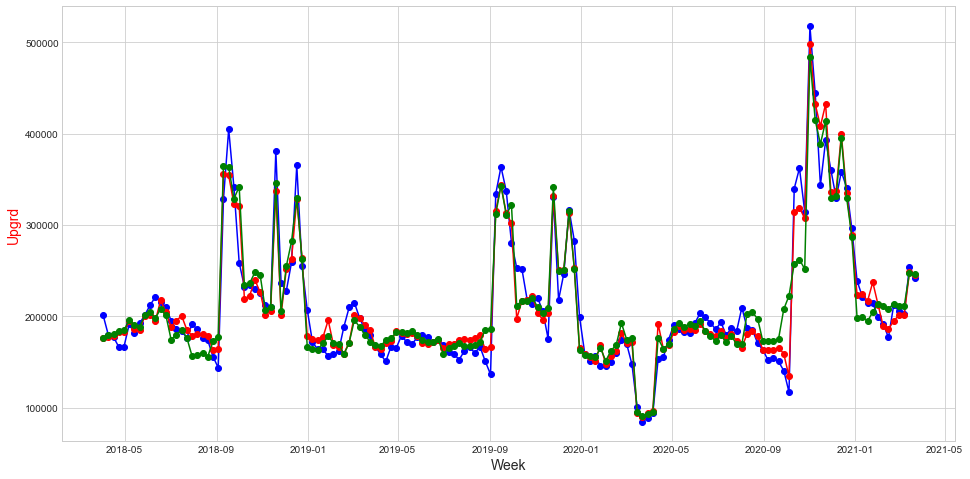

,Wk_Start_dt,Upgrd_Act,Upgrd_pred,Upgrd_pred_log
131,2020-10-05,116986.0,134101.303691,222425.072921
132,2020-10-12,339878.0,313694.483942,257528.779579
133,2020-10-19,362286.0,319006.412397,262167.175722
134,2020-10-26,314682.0,307206.715150,251810.243414
135,2020-11-02,517818.0,498043.753096,483961.244252
136,2020-11-09,444694.0,432703.127971,415001.812889
137,2020-11-16,343465.0,408264.011036,388681.496484
138,2020-11-23,392856.0,432615.722694,413865.906860
139,2020-11-30,360484.0,336176.290549,330016.640237
140,2020-12-07,329517.0,337544.585630,331286.827412


In [20]:
df= MMM_Mod_SS[['Wk_Start_dt','X_GEO','Upgrd','line_cnt']]
df['Upgrd_Act'] = y
df['Upgrd_pred'] = y_predict
df['Upgrd_pred_log'] = y_predict_log

# df['y_price_log'] = Y_price_log        

# df['y_price_sq'] = Y_price_sq          
# df['y_price_sq_1'] = y_predict        



# df1= df.groupby('Wk_Start_dt')['y','y_price','y_price_log','y_price_sq','y_price_sq_1'].sum().reset_index()
df1= df.groupby('Wk_Start_dt')['Upgrd_Act','Upgrd_pred','Upgrd_pred_log'].sum().reset_index()

              
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df1.Wk_Start_dt, df1.Upgrd_Act, color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

ax.plot(df1.Wk_Start_dt, df1.Upgrd_pred,color="red", marker="o")


# ax.plot(df1.Wk_Start_dt, df1.y_price_sq,color="yellow", marker="o")
ax.plot(df1.Wk_Start_dt, df1.Upgrd_pred_log,color="green", marker="o")




plt.show()
df1[df1.Wk_Start_dt>'2020-10-01']

# pystan bayesian model for base

In [21]:
 base_var=['RetailSale',  'OffCo_ST_SubCnt','CRO_ST_SubCnt',
       'CRO_MT_SubCnt', 'OffCo_MT_SubCnt',
          'OffCo_LT_SubCnt',
       'CRO_LT_SubCnt',  'No_Ctrt_SubCnt','Sea_Nov','Sea_Dec',
         'Phone_N_2_SubCnt', 'Phone_Oth_SubCnt','Phone_Legacy_SubCnt',
       'autopay', 'DVC_Android', 'bill_type_INTERNET','DVC_iPhone',
       'Rate_plan_StartExt_SubCnt', 'Rate_plan_Unlimited_SubCnt',
       'Rate_plan_Oth_SubCnt', 'Replicated_NoCH_STR_CNT','Sea_StimulusCheck',
         
         'CP_M_VZN_ATT_Ratio','CP_M_TMO_ATT_Ratio','Promo_VZN_ATT_Ratio','Promo_TMO_ATT_Ratio',
 
 
         'CP_M_VZN_TOT_SP', 'CP_M_TMO_TOT_SP', 'ATT_Upg_APL_sq_adj',
       'Sea_ChristmasPrior', 'Sea_Covid_Lockdown', 'Sea_Iphone_Launch',
       'Sea_Iphone_PiorLaunch', 'Sea_Samsung_PhoneRelease',
       'Sea_Thanksgiving']




In [22]:
pos_vars = ['RetailSale', 'Replicated_NoCH_STR_CNT','ATT_Upg_APL_sq_adj','Sea_Christmas',
       'Sea_ChristmasPrior',  'Sea_Iphone_Launch',
        'Sea_Samsung_PhoneRelease',  'Sea_StimulusCheck',
       'Sea_Thanksgiving'
           
           ]
# variables negatively related to sales: Competitor spend /promo

  
neg_vars =['CP_M_VZN_TOT_SP','CP_M_TMO_TOT_SP','CP_M_VZN_ATT_Ratio','CP_M_TMO_ATT_Ratio','Promo_VZN_ATT_Ratio','Promo_TMO_ATT_Ratio']
# variables may have either positive or negtive impact on sales: 
pn_vars = [col for col in base_var if (col not in pos_vars) & (col not in neg_vars) ]


    
X1 = MMM_Mod_SS[pos_vars].values
X2 = MMM_Mod_SS[neg_vars].values
X3 = MMM_Mod_SS[pn_vars].values
ctrl_data = {
    'N': len(MMM_Mod_SS),
    'K1': len(pos_vars),
    'K2': len(neg_vars), 
    'K3': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'X3': X3,    
    'y': MMM_Mod_SS['Upgrd'].values,
    'max_intercept': min(MMM_Mod_SS['Upgrd'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of negative predictors
  int K3; // number of other predictors

  
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  matrix[N, K3] X3;

  
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector<upper=0>[K2] beta2; // regression coefficients for X1 (positive)

  
  vector[K3] beta3; // regression coefficients for X2 (negative)
  
  real<upper=max_intercept> alpha; // intercept
  real noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  beta3 ~ normal(0, 1); 

  
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + X3*beta3+  alpha, noise_var);
}
'''

sm2 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
#sm1 = stan.build(ctrl_code1, data=ctrl_data,random_seed=1)
#fit1 = posterior.sample(num_chains=4,num_samples=1000)
#fit1("eta")

fit2 = sm2.sampling(data=ctrl_data, iter=2000, chains=4)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2463577464335b652cf59631044aff74 NOW.
INFO:pystan:OS: darwin, Python: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ], Cython 0.29.21


Compiling /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/stanfit4anon_model_2463577464335b652cf59631044aff74_9186552704583041269.pyx because it changed.
[1/1] Cythonizing /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/stanfit4anon_model_2463577464335b652cf59631044aff74_9186552704583041269.pyx
building 'stanfit4anon_model_2463577464335b652cf59631044aff74_9186552704583041269' extension
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var/folders
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var/folders/vp
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_7dk8qj85/var/fold

In [25]:
def extract_ctrl_model(fit_result, pos_vars=pos_vars,neg_vars=neg_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['neg_vars'] = neg_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['beta3'] = fit_result['beta3'].mean(axis=0).tolist()
    
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['beta3_list'] = fit_result['beta3'].tolist()
        
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, neg_vars ,pn_vars = ctrl_model['pos_vars'],ctrl_model['neg_vars'],ctrl_model['pn_vars'] 
    X1, X2 ,X3= df[pos_vars], df[neg_vars], df[pn_vars]
    beta1, beta2 , beta3= np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2']), np.array(ctrl_model['beta3'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2)+ np.dot(X3, beta3) + alpha
    return y_pred



base_upgrd_model = extract_ctrl_model(fit2_result, pos_vars=pos_vars,neg_vars=neg_vars, pn_vars=pn_vars)
base_upgrd = ctrl_model_predict(base_upgrd_model, MMM_Mod_SS)


MMM_Mod['base_Upgrd'] = base_upgrd*sc_ctrl['Upgrd']*MMM_Mod_SS['line_cnt']
MMM_Mod_SS['base_Upgrd'] = base_upgrd

# evaluate control model
print('mape: ', mean_absolute_percentage_error(MMM_Mod['Upgrd'], MMM_Mod['base_Upgrd']))
print('r2: ', r2_score(MMM_Mod['Upgrd'], MMM_Mod['base_Upgrd']))



mape:  11.273073607644914
r2:  0.9599484225211394


<ipython-input-26-f33ca598f42c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  check=MMM_Mod.groupby('Wk_Start_dt')['base_Upgrd','Upgrd'].sum().reset_index()


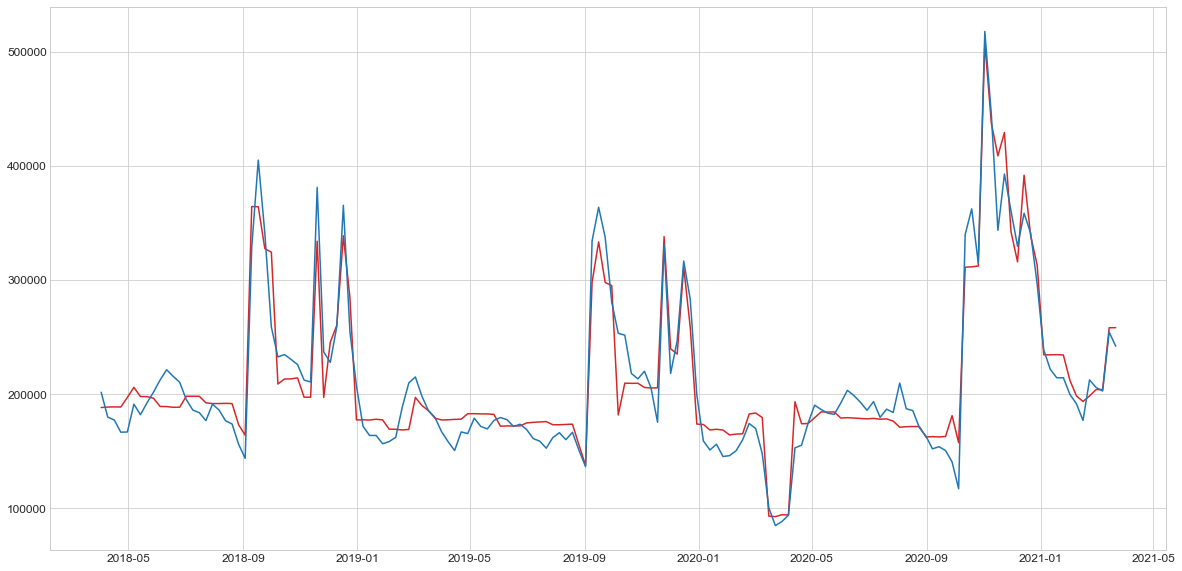

In [26]:
check=MMM_Mod.groupby('Wk_Start_dt')['base_Upgrd','Upgrd'].sum().reset_index()
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

# Specify how our lines should look
ax.plot(check.Wk_Start_dt, check.base_Upgrd, color='tab:red', label='Base Upgrade')

ax.plot(check.Wk_Start_dt, check.Upgrd, color='tab:blue', label='Total Upgrade')



In [35]:
#print(base_upgrd_model)
#print(base_upgrd_model['beta1'][2])

{'pos_vars': ['RetailSale', 'Replicated_NoCH_STR_CNT', 'ATT_Upg_APL_sq_adj', 'Sea_Christmas', 'Sea_ChristmasPrior', 'Sea_Iphone_Launch', 'Sea_Samsung_PhoneRelease', 'Sea_StimulusCheck', 'Sea_Thanksgiving'], 'neg_vars': ['CP_M_VZN_TOT_SP', 'CP_M_TMO_TOT_SP', 'CP_M_VZN_ATT_Ratio', 'CP_M_TMO_ATT_Ratio', 'Promo_VZN_ATT_Ratio', 'Promo_TMO_ATT_Ratio'], 'pn_vars': ['OffCo_ST_SubCnt', 'CRO_ST_SubCnt', 'CRO_MT_SubCnt', 'OffCo_MT_SubCnt', 'OffCo_LT_SubCnt', 'CRO_LT_SubCnt', 'No_Ctrt_SubCnt', 'Sea_Nov', 'Sea_Dec', 'Phone_N_2_SubCnt', 'Phone_Oth_SubCnt', 'Phone_Legacy_SubCnt', 'autopay', 'DVC_Android', 'bill_type_INTERNET', 'DVC_iPhone', 'Rate_plan_StartExt_SubCnt', 'Rate_plan_Unlimited_SubCnt', 'Rate_plan_Oth_SubCnt', 'Sea_Covid_Lockdown', 'Sea_Iphone_PiorLaunch'], 'beta1': [0.5750281092687892, 0.011863389547007953, 0.11786382413337429, 0.11189951003901533, 0.366330339703302, 0.8482700541351926, 0.0857408684900885, 0.28521711149721496, 0.642794656066513], 'beta2': [-0.0009639020225309773, -0.0007

In [27]:

save_json(base_upgrd_model, 'Base_model_sq_adj.json')

In [77]:
#########. If Load Old Model, only Run this 


def ctrl_model_predict(ctrl_model, df):
    pos_vars, neg_vars ,pn_vars = ctrl_model['pos_vars'],ctrl_model['neg_vars'],ctrl_model['pn_vars'] 
    X1, X2 ,X3= df[pos_vars], df[neg_vars], df[pn_vars]
    beta1, beta2 , beta3= np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2']), np.array(ctrl_model['beta3'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2)+ np.dot(X3, beta3) + alpha
    return y_pred

base_upgrd_model=load_json('Base_model_sq_adj.json')
base_upgrd = ctrl_model_predict(base_upgrd_model, MMM_Mod_SS)


MMM_Mod['base_Upgrd'] = base_upgrd*sc_ctrl['Upgrd']*MMM_Mod_SS['line_cnt']
MMM_Mod_SS['base_Upgrd'] = base_upgrd


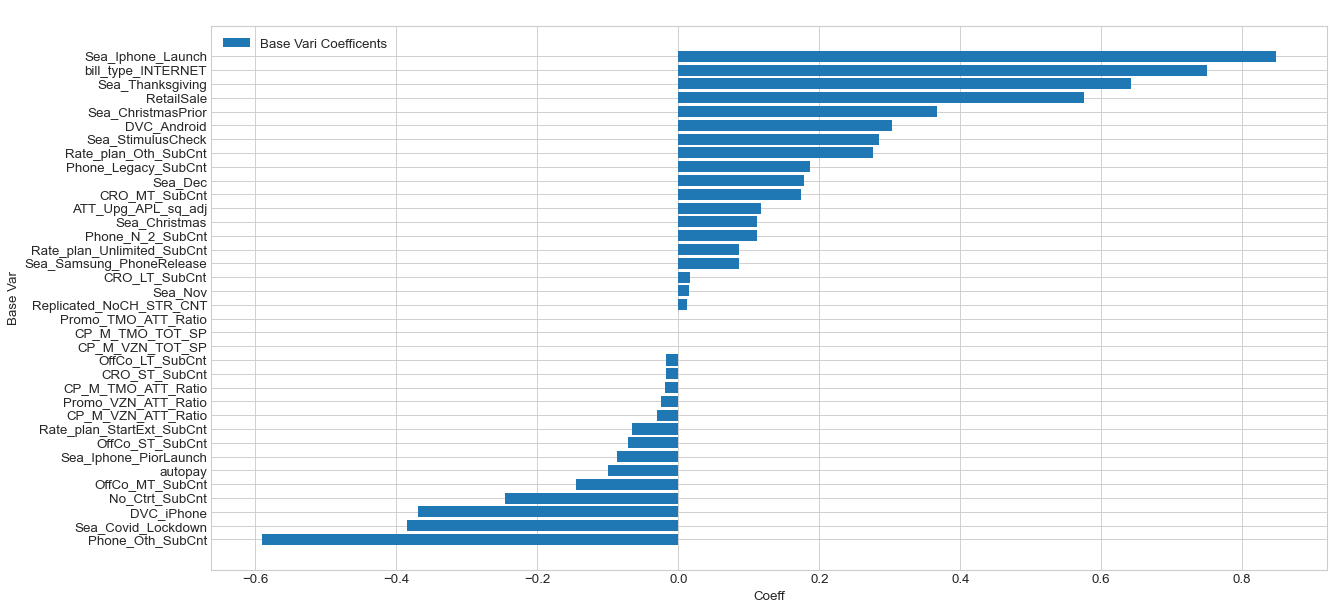

In [78]:

zipped_lists1 = zip( base_upgrd_model['beta1'],base_upgrd_model['pos_vars'])
zipped_lists2 = zip( base_upgrd_model['beta2'],base_upgrd_model['neg_vars'])
zipped_lists3 = zip( base_upgrd_model['beta3'],base_upgrd_model['pn_vars'])
zipped_lists=list(zipped_lists1)+list(zipped_lists2)+list(zipped_lists3)


sorted_pairs = sorted(zipped_lists)
base_model_df=pd.DataFrame(sorted_pairs, columns=['Coeff','Variable'])


tuples = zip(*sorted_pairs)
list1, list2 = [ list(tuple) for tuple in  tuples]

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 9), dpi=80)

# Pass the x and y cordinates of the bars to the
# function. The label argument gives a label to the data.
plt.barh(list2,
list1, align='center', label="Base Vari Coefficents")
plt.legend()

plt.ylabel('Base Var')
plt.xlabel('Coeff')
plt.title(' ')

plt.show()


#base_model_df.to_csv("~/Project/MMM1/Data/MMM_Base_Model_para.csv")

In [79]:
Base_Decom=MMM_Mod_SS[['Upgrd','Wk_Start_dt','X_GEO','Mth_End_Dt','line_cnt']+list2]
Base_Decom['base_Upgrd']=base_upgrd*sc_ctrl['Upgrd']*Base_Decom['line_cnt']
Base_Decom['Upgrd']= Base_Decom.apply (lambda x: x['Upgrd']*x['line_cnt']*sc_ctrl['Upgrd']*base_upgrd_model['beta1'][2], axis=1)


Base_Decom['Prom_Upgrd']=Base_Decom.apply (lambda x: x['ATT_Upg_APL_sq_adj']*x['line_cnt']*sc_ctrl['Upgrd']*base_upgrd_model['beta1'][2], axis=1)
Base_Decom['Prom_Upgrd_perc']=Base_Decom.apply (lambda x: x['Prom_Upgrd']/x['base_Upgrd'], axis=1)



Base_Decom['quarter'] = pd.PeriodIndex(Base_Decom['Mth_End_Dt'], freq='Q')

base_decom_df=Base_Decom.groupby('quarter')['Prom_Upgrd','base_Upgrd','Upgrd'].sum().reset_index()
base_decom_df['Promo_perc'] = base_decom_df.apply(lambda x: x['Prom_Upgrd']/x['base_Upgrd'], axis=1)

MMM_Mod['quarter'] = pd.PeriodIndex(MMM_Mod['Mth_End_Dt'], freq='Q')
MMM_Mod_df=MMM_Mod.groupby('quarter')['Upgrd'].sum().reset_index()


#base_decom_df[['quarter','Promo_perc']].merge(MMM_Mod_df, on =['quarter'])

Base_Decom.groupby('quarter')['Prom_Upgrd_perc'].mean()



<ipython-input-79-39bac7e17a22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Decom['base_Upgrd']=base_upgrd*sc_ctrl['Upgrd']*Base_Decom['line_cnt']
<ipython-input-79-39bac7e17a22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Decom['Upgrd']= Base_Decom.apply (lambda x: x['Upgrd']*x['line_cnt']*sc_ctrl['Upgrd']*base_upgrd_model['beta1'][2], axis=1)
<ipython-input-79-39bac7e17a22>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

quarter
2018Q2    0.002255
2018Q3    0.040963
2018Q4    0.023298
2019Q1    0.000000
2019Q2    0.000000
2019Q3    0.000000
2019Q4    0.089555
2020Q1    0.163147
2020Q2    0.163571
2020Q3    0.143899
2020Q4    0.343809
2021Q1    0.277411
Freq: Q-DEC, Name: Prom_Upgrd_perc, dtype: float64

# Only Run this session for Hold out 

In [80]:
MMM_Mod_Copy=MMM_Mod.copy()

#MMM_Mod=MMM_Mod_Copy
Holdout_var=list(MMM_var_dict['CDL']+MMM_var_dict['DM']+MMM_var_dict['NP']+MMM_var_dict['OD']+MMM_var_dict['OH']+MMM_var_dict['RD']+MMM_var_dict['AFF']+MMM_var_dict['CN']+MMM_var_dict['EM']+MMM_var_dict['MG']
                +Ret_Var+Halo_Media_Var)
#Holdout_var=list(MMM_var_dict['PS']+MMM_var_dict['TV']+MMM_var_dict['SM'])


Hold_Out =  pd.read_csv("~/Project/MMM_Q12021/Data/mmm_decompose_contrib_07272021.csv",parse_dates=['Wk_Start_dt','Mth_End_Dt'])
for col in Holdout_var:
    Hold_Out[col]=Hold_Out[col].apply(lambda x: 0 if x<0 else x)
Hold_Out ['Media_holdout']=Hold_Out [Holdout_var].sum(axis=1)
print(MMM_Mod_v3.Media_holdout.sum())
MMM_Mod=MMM_Mod.merge(Hold_Out[['Wk_Start_dt','X_GEO','Media_holdout']], how='left', on=['Wk_Start_dt','X_GEO'])
MMM_Mod['Upgrd_Orig']=MMM_Mod['Upgrd']
MMM_Mod['Upgrd']=MMM_Mod['Upgrd']-MMM_Mod['Media_holdout']
MMM_Mod[MMM_Mod.Upgrd>MMM_Mod.Upgrd_Orig]

272270.4544190959


,Wk_Start_dt,Wk_End_dt,Mth_End_Dt,X_GEO,OnCo_ST_SubCnt,CRO_ST_SubCnt,OffCo_ST_SubCnt,OnCo_MT_SubCnt,CRO_MT_SubCnt,OffCo_MT_SubCnt,...,Sea_Thanksgiving,Sea_StimulusCheck,Price_Adj,Upgrd,ATT_Upg_APL_log,ATT_Upg_APL_sq,ATT_Upg_APL_sq_adj,base_Upgrd,Media_holdout,Upgrd_Orig


In [81]:
Holdout_var

['MOB_M_CDL_L_IMP',
 'MOB_M_CDL_N_IMP',
 'MOB_M_DM_AME_L_PRD_CIR',
 'MOB_M_DM_CIU_L_PRD_CIR',
 'MOB_M_DM_DML_L_PRD_CIR',
 'MOB_M_DM_AME_N_PRD_CIR',
 'MOB_M_DM_CIU_N_PRD_CIR',
 'MOB_M_DM_DML_N_PRD_CIR',
 'MOB_M_NP_L_PRD_CIR',
 'MOB_M_NP_N_PRD_CIR',
 'MOB_M_OD_L_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OD_N_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OD_OAD_PRD_OTH_GM_IMP',
 'MOB_M_OD_OAD_PRD_PRF_GM_IMP',
 'MOB_M_OD_OAD_PRD_UPF_GM_IMP',
 'MOB_M_OD_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OD_OGN_PRD_PRF_GM_IMP',
 'MOB_M_OD_OGN_PRD_UPF_GM_IMP',
 'MOB_M_OD_OVD_PRD_OTH_GM_IMP',
 'MOB_M_OD_OVD_PRD_PRF_GM_IMP',
 'MOB_M_OD_OVD_PRD_UPF_GM_IMP',
 'MOB_M_OD_PRD_HM_IMP',
 'MOB_M_OH_L_PRD_IMP',
 'MOB_M_OH_N_PRD_IMP',
 'MOB_M_RD_L_PRD_GM_GRP',
 'MOB_M_RD_L_PRD_HM_GRP',
 'MOB_M_RD_BC_N_PRD_GRP',
 'MOB_M_AFF_PRD_CLK',
 'MOB_M_CN_N_PRD_IMP',
 'MOB_M_EM_PRD_CIR',
 'MOB_M_MG_PRD_CIR',
 'RET_XANDR_IMP',
 'RET_SNP_IMP',
 'RET_FB_IMP',
 'BBD_M_DM_DML_N_PRD_CIR',
 'BBD_M_OH_L_PRD_IMP',
 'BBD_M_PS_PRD_BND_CLK',
 'FIB_M_CN_N_PRD_IMP',
 'FIB_M_OD_N_O

In [82]:
Hold_Out  =Hold_Out[Hold_Out['Wk_Start_dt']>='2020-10-01'].reset_index()
MMM_Mod =MMM_Mod[MMM_Mod['Wk_Start_dt']>='2020-10-01'].reset_index()

MMM_Mod_Scale = MMM_Mod.copy()
#var_toscale = MMM_Control.columns[[np.issubdtype(dt, np.number) for dt in MMM_Control.dtypes]].to_list().remove('line_cnt'')
for item in Control_Var+Target_Var:
    if item != 'line_cnt':
        MMM_Mod_Scale[item]=MMM_Mod_Scale[item]/MMM_Mod_Scale['line_cnt']

MMM_Mod_Scale       

,index,Wk_Start_dt,Wk_End_dt,Mth_End_Dt,X_GEO,OnCo_ST_SubCnt,CRO_ST_SubCnt,OffCo_ST_SubCnt,OnCo_MT_SubCnt,CRO_MT_SubCnt,...,Sea_Thanksgiving,Sea_StimulusCheck,Price_Adj,Upgrd,ATT_Upg_APL_log,ATT_Upg_APL_sq,ATT_Upg_APL_sq_adj,base_Upgrd,Media_holdout,Upgrd_Orig
0,298,2020-10-05,2020-10-11,2020-10-31,EIO,0.196400,0.018066,0.026064,0.053809,0.006139,...,0,0,1.0000,0.001714,5.707110,90000,90000,1617.664378,12.756700,1191
1,299,2020-10-12,2020-10-18,2020-10-31,REA,0.241213,0.022296,0.030153,0.072184,0.007772,...,0,0,1.0000,0.005767,6.685861,640000,640000,2475.667570,100.675730,2964
2,300,2020-10-19,2020-10-25,2020-10-31,CNA,0.179648,0.018830,0.027010,0.053975,0.006386,...,0,0,1.0000,0.005285,6.685861,640000,640000,5913.838245,216.885480,6365
3,301,2020-10-26,2020-11-01,2020-10-31,PAP,0.179900,0.016983,0.023415,0.054766,0.006158,...,0,0,1.0000,0.004914,6.685861,640000,640000,8041.992154,241.319887,8142
4,302,2020-11-02,2020-11-08,2020-11-30,OEA,0.194801,0.014358,0.026620,0.055166,0.005232,...,0,0,1.0000,0.008621,6.552508,490000,490000,7405.515889,531.160783,8495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,8815,2021-03-15,2021-03-21,2021-03-31,CNA,0.192127,0.014171,0.020546,0.059167,0.004934,...,0,1,0.4096,0.003513,6.439350,390625,160000,4943.126968,54.309922,4182
1480,8816,2021-03-15,2021-03-21,2021-03-31,HNH,0.205873,0.013775,0.017413,0.052737,0.004483,...,0,1,0.4096,0.003289,6.439350,390625,160000,2421.489184,30.593586,2006
1481,8817,2021-03-22,2021-03-28,2021-03-31,ANT,0.165709,0.012510,0.019903,0.063647,0.005141,...,0,1,0.4096,0.003609,6.439350,390625,160000,2822.517497,171.253887,2971
1482,8818,2021-03-22,2021-03-28,2021-03-31,BAM,0.183625,0.012343,0.018480,0.065254,0.005171,...,0,1,0.4096,0.003320,6.439350,390625,160000,2180.729402,29.915717,1768


# pystan bayesian model for MMM


In [83]:
Media_Var=['MOB_M_CDL_L_IMP',
 'MOB_M_DM_AME_L_PRD_CIR',
 'MOB_M_DM_CIU_L_PRD_CIR',
 'MOB_M_DM_DML_L_PRD_CIR',
 'MOB_M_NP_L_PRD_CIR',
 'MOB_M_OD_L_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OH_L_PRD_IMP',
 'MOB_M_RD_L_PRD_GM_GRP',
 'MOB_M_RD_L_PRD_HM_GRP',
 #'MOB_M_TV_LN_L_PRD_GM_GRP',
 'MOB_M_AFF_PRD_CLK',
 'MOB_M_CDL_N_IMP',
 'MOB_M_CN_N_PRD_IMP',
 'MOB_M_DM_AME_N_PRD_CIR',
 'MOB_M_DM_CIU_N_PRD_CIR',
 'MOB_M_DM_DML_N_PRD_CIR',
 'MOB_M_EM_PRD_CIR',
 'MOB_M_MG_PRD_CIR',
 'MOB_M_NP_N_PRD_CIR',
 'MOB_M_OD_N_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OD_OAD_PRD_OTH_GM_IMP',
 'MOB_M_OD_OAD_PRD_PRF_GM_IMP',
 'MOB_M_OD_OAD_PRD_UPF_GM_IMP',
 'MOB_M_OD_OGN_PRD_OTH_GM_IMP',
 'MOB_M_OD_OGN_PRD_PRF_GM_IMP',
 'MOB_M_OD_OGN_PRD_UPF_GM_IMP',
 'MOB_M_OD_OVD_PRD_OTH_GM_IMP',
 'MOB_M_OD_OVD_PRD_PRF_GM_IMP',
 'MOB_M_OD_OVD_PRD_UPF_GM_IMP',
 'MOB_M_OD_PRD_HM_IMP',
 'MOB_M_OH_N_PRD_IMP',
 'MOB_M_PS_PRD_BND_CLK',
 'MOB_M_PS_PRD_NBD_CLK',
 'MOB_M_PS_PRD_SHP_CLK',
 'MOB_M_RD_BC_N_PRD_GRP',
 'MOB_M_SM_FB_PRD_OTH_IMP',
  'MOB_M_SM_FB_PRD_PRF_IMP',
 'MOB_M_SM_FB_PRD_UPF_IMP',
 'MOB_M_SM_OT_PRD_IMP',
 'MOB_M_SM_ST_PRD_IMP',
 'MOB_M_SM_TW_PRD_IMP',
  'MOB_M_TV_AD_PRD_IMP',
'MOB_M_TV_LN_N_PRD_GM_GRP',
  'MOB_M_TV_LN_N_PRD_HM_GRP',
          ]


MMM_var_dict=dict()
for col in Media_Var:
    media= col.split('_')[2]
    if media not in MMM_var_dict:
        MMM_var_dict[media]= [col]
    else:
        MMM_var_dict[media].append(col)
    
Ret_Var= ['RET_XANDR_IMP','RET_SNP_IMP','RET_FB_IMP']

Halo_Media_Var=['BBD_M_DM_DML_N_PRD_CIR',
 'BBD_M_OH_L_PRD_IMP',
 'BBD_M_PS_PRD_BND_CLK',
 'DTN_M_RD_BC_N_PRD_GRP',
 'DTN_M_TV_LN_N_PRD_GM_GRP',
 'FIB_M_CN_N_PRD_IMP',
 'FIB_M_MG_PRD_CIR',
 'FIB_M_OD_N_OGN_PRD_OTH_GM_IMP',
 'FIB_M_OD_OAD_PRD_OTH_GM_IMP',
 'FIB_M_OD_OGN_PRD_OTH_GM_IMP',
 'FIB_M_OD_OVD_PRD_OTH_GM_IMP',
 'FIB_M_OD_PRD_HM_IMP',
 'FIB_M_PS_PRD_NBD_CLK',
 'FIB_M_RD_L_PRD_GM_GRP',
 'FIB_M_RD_L_PRD_HM_GRP',
 'FIB_M_SM_FB_PRD_OTH_IMP',
 'FIB_M_TV_AD_PRD_IMP',
 'FIB_M_TV_LN_L_PRD_GM_GRP',
 'Replicated_M_AFF_ITA_CLK',
 'Replicated_M_DM_AME_N_BDL_CIR',
 'Replicated_M_DM_DML_N_BDL_CIR',
 'Replicated_M_OD_OVD_BRD_GM_IMP',
 'Replicated_M_PS_TRM_CLK',
  'Replicated_M_RD_BC_N_BRD_GRP',
 'Replicated_M_RD_L_ITA_HM_GRP',
 'VID_M_AFF_PRD_CLK',
 'VID_M_DM_DML_N_PRD_CIR',
 'VID_M_OD_PRD_HM_IMP',
 'VID_M_RD_L_PRD_HM_GRP',
'VID_M_TV_LN_L_PRD_HM_GRP',
 'VID_M_TV_LN_N_PRD_GM_GRP',
 'VID_M_TV_LN_N_PRD_HM_GRP']


In [123]:
#MMM_Mod['base_Upgrd']=MMM_Mod['base_Upgrd_log'].fillna(0)
MMM_Mod

,index,Wk_Start_dt,Wk_End_dt,Mth_End_Dt,X_GEO,Upgrd,Churn,OnCo_ST_SubCnt,CRO_ST_SubCnt,OffCo_ST_SubCnt,...,Sea_Samsung_PhoneRelease,Sea_Thanksgiving,Sea_StimulusCheck,Price_Adj,ATT_Upg_APL_log,ATT_Upg_APL_sq,ATT_Upg_APL_sq_adj,base_Upgrd,Media_holdout,Upgrd_Orig
0,298,2020-10-05,2020-10-11,2020-10-31,EIO,1053.944218,1083,135009,12419,17917,...,0.0,0,0,1.0000,5.707110,90000,90000.0,1448.395866,5.055782,1059
1,299,2020-10-12,2020-10-18,2020-10-31,REA,2795.161682,835,119764,11070,14971,...,0.0,0,0,1.0000,6.685861,640000,640000.0,2379.563516,57.838318,2853
2,300,2020-10-19,2020-10-25,2020-10-31,CNA,5223.785863,2028,208986,21905,31421,...,0.0,0,0,1.0000,6.685861,640000,640000.0,5383.340545,65.214137,5289
3,301,2020-10-26,2020-11-01,2020-10-31,PAP,7264.039548,3036,289231,27304,37645,...,0.0,0,0,1.0000,6.685861,640000,640000.0,7595.020346,83.960452,7348
4,302,2020-11-02,2020-11-08,2020-11-30,OEA,7840.308425,2068,179948,13263,24590,...,0.0,0,0,1.0000,6.552508,490000,490000.0,6476.326179,354.691575,8195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8731,2021-03-15,2021-03-21,2021-03-31,CNA,3953.741674,2333,225755,16651,24142,...,0.0,0,1,0.4096,6.439350,390625,160000.0,4376.407095,110.258326,4064
1396,8732,2021-03-15,2021-03-21,2021-03-31,HNH,1906.002893,1064,123631,8272,10457,...,0.0,0,1,0.4096,6.439350,390625,160000.0,2252.868458,40.997107,1947
1397,8733,2021-03-22,2021-03-28,2021-03-31,ANT,2729.355559,1126,128549,9705,15440,...,0.0,0,1,0.4096,6.439350,390625,160000.0,2820.489410,131.644441,2861
1398,8734,2021-03-22,2021-03-28,2021-03-31,BAM,1679.309825,909,96123,6461,9674,...,0.0,0,1,0.4096,6.439350,390625,160000.0,1973.816180,42.690175,1722


In [84]:

#MMM_Mod_Scale=MMM_Mod_Scale.fillna(0)


Zero_var=[]
for item in Target_Var+['base_Upgrd']+Media_Var+Ret_Var+Halo_Media_Var:
    if MMM_Mod[item].sum()==0:
        Zero_var.append(item)
    
print(Zero_var)

# Media_Var=[col for col in Media_Var if 'MOB_M_' in col]
var_toTransform = [col for col in Target_Var+['base_Upgrd']+Media_Var+Ret_Var+Halo_Media_Var if col not in Zero_var]
df_ctrl, sc_log_ctrl = mean_log1p_trandform(MMM_Mod, var_toTransform)

MMM_Mod_MeanLog= pd.concat([df_ctrl, MMM_Mod[['Wk_Start_dt','X_GEO','line_cnt']]], axis=1)
MMM_Mod_MeanLog

['MOB_M_DM_AME_L_PRD_CIR', 'MOB_M_DM_CIU_L_PRD_CIR', 'MOB_M_DM_AME_N_PRD_CIR', 'MOB_M_DM_CIU_N_PRD_CIR', 'MOB_M_OH_N_PRD_IMP', 'DTN_M_RD_BC_N_PRD_GRP', 'DTN_M_TV_LN_N_PRD_GM_GRP', 'FIB_M_MG_PRD_CIR', 'Replicated_M_RD_L_ITA_HM_GRP', 'VID_M_RD_L_PRD_HM_GRP', 'VID_M_TV_LN_L_PRD_HM_GRP', 'VID_M_TV_LN_N_PRD_GM_GRP', 'VID_M_TV_LN_N_PRD_HM_GRP']


,Upgrd,base_Upgrd,MOB_M_CDL_L_IMP,MOB_M_DM_DML_L_PRD_CIR,MOB_M_NP_L_PRD_CIR,MOB_M_OD_L_OGN_PRD_OTH_GM_IMP,MOB_M_OH_L_PRD_IMP,MOB_M_RD_L_PRD_GM_GRP,MOB_M_RD_L_PRD_HM_GRP,MOB_M_AFF_PRD_CLK,...,Replicated_M_DM_DML_N_BDL_CIR,Replicated_M_OD_OVD_BRD_GM_IMP,Replicated_M_PS_TRM_CLK,Replicated_M_RD_BC_N_BRD_GRP,VID_M_AFF_PRD_CLK,VID_M_DM_DML_N_PRD_CIR,VID_M_OD_PRD_HM_IMP,Wk_Start_dt,X_GEO,line_cnt
0,0.227897,0.286109,0.363650,0.130208,0.000000,0.000000,0.596623,0.021278,4.081175,0.629406,...,0.442390,0.000000,1.005363,0.0,0.599951,0.788306,1.017536,2020-10-05,EIO,687418
1,0.483669,0.410071,0.600415,0.079122,0.000000,0.000000,0.000000,0.000000,0.000000,0.921724,...,0.502492,0.000000,1.227694,0.0,0.614321,0.816892,1.218170,2020-10-12,REA,496508
2,0.848262,0.793415,0.506542,1.255552,0.000000,0.000000,0.000000,0.000000,0.000000,0.839716,...,0.278317,0.000000,1.207964,0.0,0.905818,0.848735,1.202574,2020-10-19,CNA,1163311
3,0.999272,0.973313,1.280176,0.322250,0.000000,0.000000,0.000000,0.000000,0.000000,0.776528,...,0.101625,0.061515,1.195451,0.0,0.596842,0.629545,1.105632,2020-10-26,PAP,1607730
4,1.004310,0.922818,1.119527,0.489992,0.000000,0.000000,1.708491,0.000000,0.000000,0.804372,...,0.052103,0.483138,1.210118,0.0,0.645764,0.355049,1.110209,2020-11-02,OEA,923755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,0.640104,0.699212,0.460200,0.610013,0.000000,1.340550,0.000000,0.000000,0.000000,0.673436,...,0.186303,0.034535,0.000000,0.0,0.792342,0.721786,0.000000,2021-03-15,CNA,1175029
1480,0.357064,0.402681,0.432966,0.003461,0.000000,1.825574,0.000000,0.000000,0.000000,0.673436,...,0.186303,0.034535,0.000000,0.0,0.792342,0.721786,0.000000,2021-03-15,HNH,600522
1481,0.475117,0.456124,0.182454,0.105629,2.550083,1.337411,0.000000,0.000000,0.000000,0.653390,...,0.096739,0.016203,0.000000,0.0,0.732699,0.597968,0.000000,2021-03-22,ANT,775750
1482,0.320323,0.369169,0.909768,0.003283,0.000000,1.524029,0.000000,0.000000,0.000000,0.653390,...,0.096739,0.016203,0.000000,0.0,0.732699,0.597968,0.000000,2021-03-22,BAM,523474


In [20]:
Holdout_var=[]
mdip_cols=[col for col in Media_Var+Ret_Var+Halo_Media_Var if (col not in Holdout_var) & (col not in Zero_var) ]


In [85]:
#mdip_cols=['BBD_M_DM_DML_L_PRD_CIR', 'BBD_M_OH_L_PRD_IMP', 'FIB_M_CDL_L_TRP', 'FIB_M_OD_L_OGN_PRD_OTH_GM_IMP', 'FIB_M_RD_L_PRD_GM_IMP', 'FIB_M_RD_L_PRD_HM_GRP', 'FIB_M_TV_LN_L_PRD_GM_IMP', 'MOB_M_CDL_L_TRP', 'MOB_M_DM_DML_L_PRD_CIR', 'MOB_M_RD_L_PRD_GM_IMP', 'MOB_M_RD_L_PRD_HM_GRP', 'Replicated_M_DM_AME_L_BDL_CIR', 'Replicated_M_NP_L_BRD_CIR', 'Replicated_M_TV_LN_L_ITA_GM_IMP', 'VID_M_DM_CIU_L_PRD_CIR', 'VID_M_OD_L_OGN_PRD_OTH_GM_IMP', 'VID_M_TV_LN_L_PRD_GM_IMP', 'VID_M_TV_LN_L_PRD_HM_GRP', 'BBD_M_EM_PRD_CIR', 'BBD_M_OD_OGN_PRD_PRF_GM_IMP', 'BBD_M_OD_OGN_PRD_UPF_GM_IMP', 'BBD_M_OD_OVD_PRD_UPF_GM_IMP', 'BBD_M_OD_PRD_HM_IMP', 'BBD_M_OH_N_PRD_IMP', 'BBD_M_PS_PRD_BND_CLK', 'BBD_M_PS_PRD_NBD_CLK', 'BBD_M_SM_OT_PRD_IMP', 'BBD_M_SM_TW_PRD_IMP', 'EXL_M_PS_PRD_NBD_CLK', 'FIB_M_CDL_N_TRP', 'FIB_M_CN_N_PRD_IMP', 'FIB_M_DM_DML_N_PRD_CIR', 'FIB_M_MG_PRD_CIR', 'FIB_M_OD_OAD_PRD_PRF_GM_IMP', 'FIB_M_OD_OAD_PRD_UPF_GM_IMP', 'FIB_M_OD_OGN_PRD_UPF_GM_IMP', 'FIB_M_OD_OVD_PRD_OTH_GM_IMP', 'FIB_M_OD_OVD_PRD_PRF_GM_IMP', 'FIB_M_OD_PRD_HM_IMP', 'FIB_M_OH_N_PRD_IMP', 'FIB_M_PS_PRD_NBD_CLK', 'FIB_M_SM_OT_PRD_IMP', 'FIB_M_SM_ST_PRD_IMP', 'MOB_M_CDL_N_IMP', 'MOB_M_DM_CIU_N_PRD_CIR', 'MOB_M_NP_N_PRD_CIR', 'MOB_M_OD_OAD_PRD_OTH_GM_IMP', 'MOB_M_OD_OGN_PRD_PRF_GM_IMP', 'MOB_M_OD_OVD_PRD_PRF_GM_IMP', 'MOB_M_PS_PRD_BND_CLK', 'MOB_M_SM_FB_PRD_OTH_IMP', 'MOB_M_SM_FB_PRD_PRF_IMP', 'MOB_M_SM_FB_PRD_UPF_IMP', 'MOB_M_SM_TW_PRD_IMP', 'Replicated_M_AFF_BDL_CLK', 'Replicated_M_AFF_ITA_CLK', 'Replicated_M_DM_DML_N_BDL_CIR', 'Replicated_M_NP_N_BRD_CIR', 'Replicated_M_OD_BRD_HM_IMP', 'Replicated_M_OD_OAD_BDL_GM_IMP', 'Replicated_M_OD_OAD_BRD_GM_IMP', 'Replicated_M_OD_OVD_BDL_GM_IMP', 'Replicated_M_PS_BDL_IMP', 'Replicated_M_PS_TRM_CLK', 'Replicated_M_RD_BC_N_BRD_GRP', 'Replicated_M_SM_FB_BDL_IMP', 'Replicated_M_SM_OT_BRD_IMP', 'Replicated_M_TV_LN_N_BRD_GRP', 'VID_M_CDL_N_TRP', 'VID_M_DM_AME_N_PRD_CIR', 'VID_M_DM_DML_N_PRD_CIR', 'VID_M_NP_N_PRD_CIR', 'VID_M_OD_OAD_PRD_PRF_GM_IMP', 'VID_M_OD_OAD_PRD_UPF_GM_IMP', 'VID_M_OD_OGN_PRD_OTH_GM_IMP', 'VID_M_OD_OVD_PRD_OTH_GM_IMP', 'VID_M_OD_OVD_PRD_PRF_GM_IMP', 'VID_M_OH_N_PRD_IMP', 'VID_M_PS_PRD_BND_CLK', 'VID_M_PS_PRD_NBD_CLK', 'VID_M_RD_BC_N_PRD_GRP', 'VID_M_SM_FB_PRD_UPF_IMP', 'VID_M_SM_TW_PRD_IMP', 'VID_M_TV_LN_N_PRD_GM_GRP']


mdip_cols=[col for col in Media_Var+Ret_Var+Halo_Media_Var if (col not in Holdout_var) & (col not in Zero_var) ]
print(mdip_cols)
#mdip_cols=MMM_var_dict['SM']
num_media = len(mdip_cols)
X_media = MMM_Mod_MeanLog[mdip_cols].values
X_ctrl = MMM_Mod_MeanLog['base_Upgrd'].values.reshape(len(MMM_Mod_MeanLog),1)
# Weight = MMM_Mod_MeanLog['Weight'].values
model_data2 = {
    'N': len(MMM_Mod_MeanLog),
    'num_media': num_media,
    'X_media': X_media, 
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
#     'Weight':Weight,
    'y': MMM_Mod_MeanLog['Upgrd'].values
}

model_code2 = '''

data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
 // the vector of Weights
 // real Weight[N];

  
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N, num_media] X_media;
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}


parameters {
  vector[num_ctrl] beta_ctrl; // regression coefficients for control
  vector<lower=0>[num_media] beta_media; // regression coefficients for media (positive)
    
  real alpha; // intercept
  real noise_var; // residual variance
}

model {
  // Define the priors
  beta_ctrl ~ normal(0, 1); 
  beta_media ~ normal(0, 1); 
//  beta_media[0] < beta_media[41];
//  beta_media[0] < beta_media[42];
  
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X_ctrl*beta_ctrl + X_media*beta_media +  alpha, noise_var);
     
 //    for (i in 1 : N) {
 //        target += Weight[i] * normal_lpdf(y[i] | X_ctrl[i]*beta_ctrl + X_media[i]*beta_media +  alpha, noise_var);
 //   }
 
}
'''



sm3 = pystan.StanModel(model_code=model_code2, verbose=True)
fit3 = sm3.sampling(data=model_data2, iter=2000, chains=4)
fit3_result = fit3.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_264b7976004ca60b2beb9963ae49d2ea NOW.
INFO:pystan:OS: darwin, Python: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ], Cython 0.29.21


['MOB_M_PS_PRD_BND_CLK', 'MOB_M_PS_PRD_NBD_CLK', 'MOB_M_PS_PRD_SHP_CLK', 'MOB_M_SM_FB_PRD_OTH_IMP', 'MOB_M_SM_FB_PRD_PRF_IMP', 'MOB_M_SM_FB_PRD_UPF_IMP', 'MOB_M_SM_OT_PRD_IMP', 'MOB_M_SM_ST_PRD_IMP', 'MOB_M_SM_TW_PRD_IMP', 'MOB_M_TV_AD_PRD_IMP', 'MOB_M_TV_LN_N_PRD_GM_GRP', 'MOB_M_TV_LN_N_PRD_HM_GRP']
Compiling /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_4zcahvns/stanfit4anon_model_264b7976004ca60b2beb9963ae49d2ea_8144924458965059381.pyx because it changed.
[1/1] Cythonizing /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_4zcahvns/stanfit4anon_model_264b7976004ca60b2beb9963ae49d2ea_8144924458965059381.pyx
building 'stanfit4anon_model_264b7976004ca60b2beb9963ae49d2ea_8144924458965059381' extension
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_4zcahvns/var
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_4zcahvns/var/folders
creating /var/folders/vp/dvyy35qx27q8r9sy38xblfww0000gq/T/pystan_4zcahvns/var/folders/vp
creating /var/folders/

/Users/jl799w/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jl799w/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jl799w/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

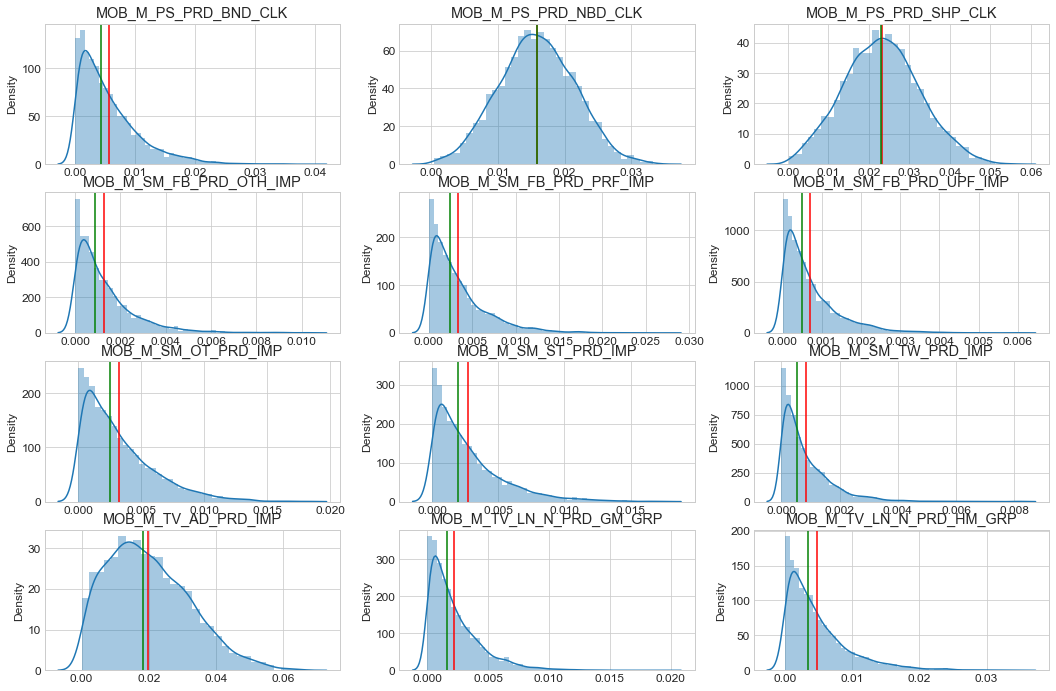

In [86]:
# extract mmm parameters
#mdip_cols=[col for col in Media_Var+Ret_Var+Halo_Media_Var if (col not in Holdout_var) & (col not in Zero_var)]

def extract_mmm(fit_result, ctrl_vars=['base_Upgrd'],mdip_cols=mdip_cols, 
                       extract_param_list=True):
    ctrl_model = {}
    
    ctrl_model['ctrl_vars'] = ctrl_vars
    ctrl_model['media_vars'] = mdip_cols
    
    ctrl_model['beta_ctrl'] = fit_result['beta_ctrl'].mean(axis=0).tolist()
    ctrl_model['beta_media'] = fit_result['beta_media'].mean(axis=0).tolist()
     
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta_ctrl_list'] = fit_result['beta_ctrl'].tolist()
        ctrl_model['beta_media_list'] = fit_result['beta_media'].tolist()
      
        
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

mmm = extract_mmm(fit3_result)
# save_json(mmm, 'mmm1.json')
#mmm=load_json('mmm_v1.json')


# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_media_list'])):
        betas.append(mmm['beta_media_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)


In [87]:
#save_json(mmm, 'mmm_v1.json')

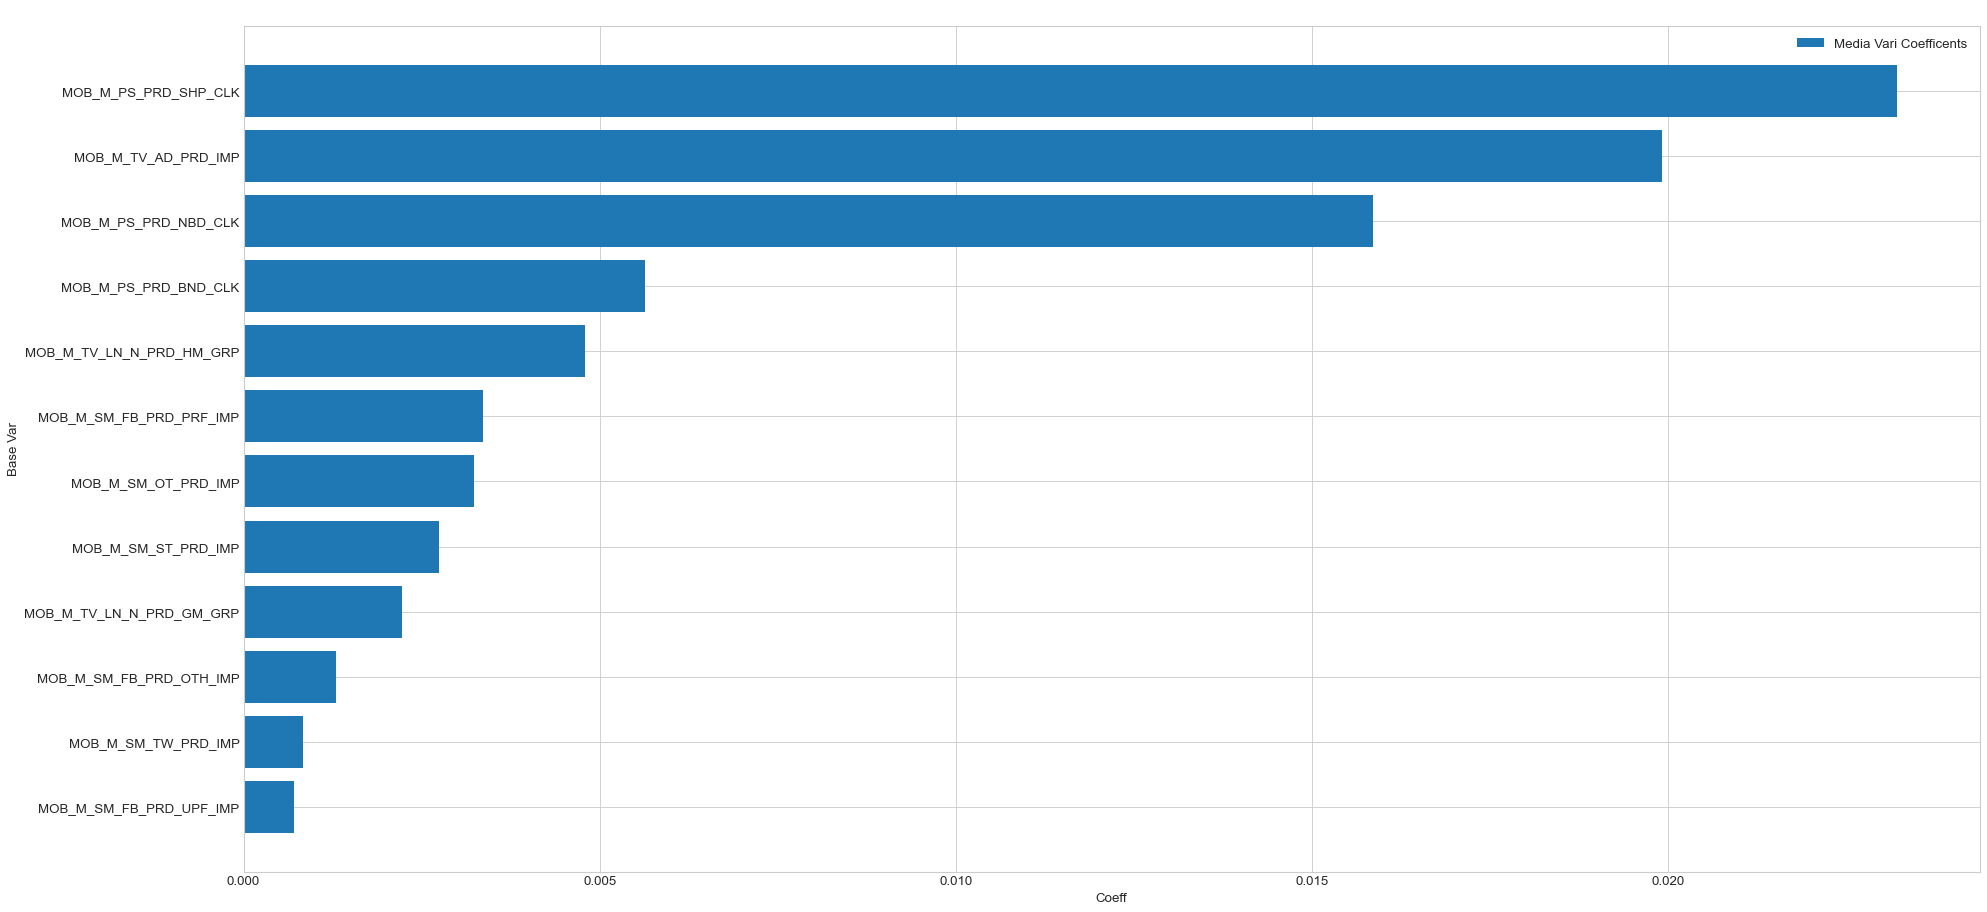

['MOB_M_SM_FB_PRD_UPF_IMP', 'MOB_M_SM_TW_PRD_IMP', 'MOB_M_SM_FB_PRD_OTH_IMP', 'MOB_M_TV_LN_N_PRD_GM_GRP', 'MOB_M_SM_ST_PRD_IMP', 'MOB_M_SM_OT_PRD_IMP', 'MOB_M_SM_FB_PRD_PRF_IMP', 'MOB_M_TV_LN_N_PRD_HM_GRP', 'MOB_M_PS_PRD_BND_CLK', 'MOB_M_PS_PRD_NBD_CLK', 'MOB_M_TV_AD_PRD_IMP', 'MOB_M_PS_PRD_SHP_CLK']
[0.0007015493658869518, 0.0008331266255187315, 0.0012971387834292743, 0.00223052465334115, 0.002739887023743811, 0.0032312130821629402, 0.0033658440497465157, 0.00479598504086719, 0.005632285862757859, 0.015851823238647773, 0.019909252971934212, 0.023213120134214733]
['MOB_M_PS_PRD_BND_CLK', 'MOB_M_PS_PRD_NBD_CLK', 'MOB_M_PS_PRD_SHP_CLK', 'MOB_M_SM_FB_PRD_OTH_IMP', 'MOB_M_SM_FB_PRD_PRF_IMP', 'MOB_M_SM_FB_PRD_UPF_IMP', 'MOB_M_SM_OT_PRD_IMP', 'MOB_M_SM_ST_PRD_IMP', 'MOB_M_SM_TW_PRD_IMP', 'MOB_M_TV_AD_PRD_IMP', 'MOB_M_TV_LN_N_PRD_GM_GRP', 'MOB_M_TV_LN_N_PRD_HM_GRP']


['MOB_M_SM_FB_PRD_UPF_IMP',
 'MOB_M_SM_TW_PRD_IMP',
 'MOB_M_SM_FB_PRD_OTH_IMP',
 'MOB_M_TV_LN_N_PRD_GM_GRP',
 'MOB_M_SM_ST_PRD_IMP',
 'MOB_M_SM_OT_PRD_IMP',
 'MOB_M_SM_FB_PRD_PRF_IMP',
 'MOB_M_TV_LN_N_PRD_HM_GRP',
 'MOB_M_PS_PRD_BND_CLK',
 'MOB_M_PS_PRD_NBD_CLK',
 'MOB_M_TV_AD_PRD_IMP',
 'MOB_M_PS_PRD_SHP_CLK']

In [88]:
mmm_zipped_lists = zip( mmm['beta_media'],mmm['media_vars'])



mmm_sorted_pairs = sorted(mmm_zipped_lists)

mmm_tuples = zip(*mmm_sorted_pairs)
mmm_list1, mmm_list2 = [ list(tuple) for tuple in  mmm_tuples]

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(28, 14), dpi=80)

# Pass the x and y cordinates of the bars to the
# function. The label argument gives a label to the data.
plt.barh(mmm_list2,
mmm_list1, align='center', label="Media Vari Coefficents")
plt.legend()

plt.ylabel('Base Var')
plt.xlabel('Coeff')
plt.title(' ')

plt.show()

print(mmm_list2)
print(mmm_list1)
print(mdip_cols)
mmm_list2


In [89]:
# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=MMM_Mod['Upgrd']):
    # adstock params
    adstock_params = AdStock_params
    # coefficients, intercept
    beta, beta_ctrl,  tau = mmm['beta_media'], mmm['beta_ctrl'],mmm['alpha']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = df[media_vars]
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['Upgrd'])
    print(sc_mmm2_2)
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^alpha
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta_ctrl[i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=['Wk_Start_dt','Mth_End_Dt','X_GEO']+media_vars+['baseline'])
    mc_df[['Wk_Start_dt','Mth_End_Dt','X_GEO']]=df[['Wk_Start_dt','Mth_End_Dt','X_GEO']]
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df.apply(lambda x: x['y_true2'] if x['baseline']> x['y_true2'] else x['baseline'], axis=1)
    mc_df['y_true2'] = factor_df['y_true2']
    mc_df['y_pred'] = factor_df['y_pred']
    mc_df['Upgrade_pred'] = (mc_df['y_pred']-1)*sc_mmm2_2['Upgrd']
 #   mc_df['baseline']= mc_df.apply(lambda x: x['y_true2'] if x['baseline']> x['y_true2'] else x['baseline'])
    #mc_df['Upgrd_pred']=mc_df['y_pred']*sc_mmm2_2

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['Upgrd'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['Upgrd']/mc_df['y_true2']
        mc_df[col] =mc_df[col].apply(lambda x: 0 if x<0 else x)
    
#     print('rmse (log-log model): ', 
#          mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
#     print('mape (multiplicative model): ', 
#          mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col=['Upgrd'], period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2
mdip_cols=[col for col in Media_Var+Ret_Var+Halo_Media_Var if col not in Holdout_var]

mc_df = mmm_decompose_contrib(mmm, MMM_Mod, original_sales=MMM_Mod['Upgrd'])
#adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')





{'Upgrd': 4603.312576715439}


In [90]:
mape_df=mc_df[['y_true2','y_pred']].copy()
mape_df['APE']=mape_df.apply(lambda  row: np.abs(row.y_true2-  row.y_pred)/row.y_true2, axis=1)
print(np.mean(mape_df['APE']))
  

0.03623996268327561


-------  Total Upgrade -------
MAPE: 0.05188129079631529
RMSE: 13053.428438549872
R2: 0.9575386902095492
Durbin Watson: 1.5941347372825683


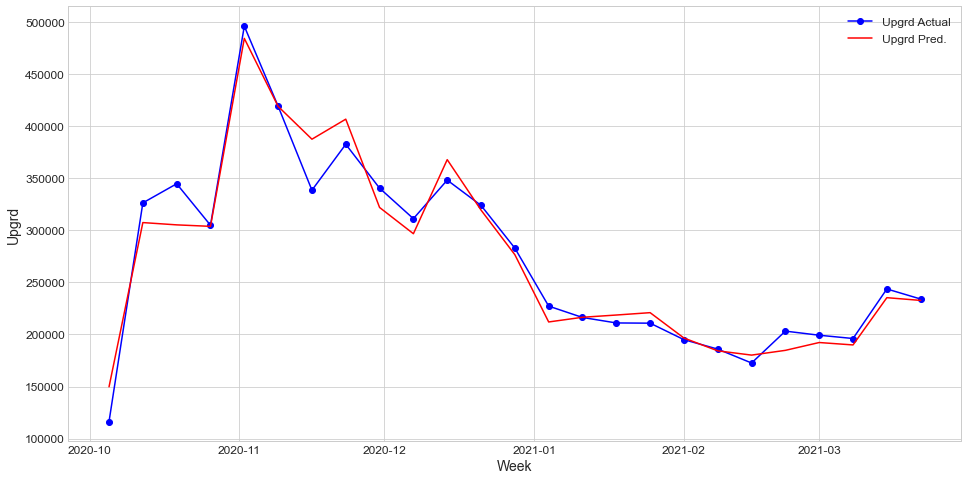

In [91]:
from statsmodels.stats.stattools import durbin_watson
agg_d= mc_df.groupby('Wk_Start_dt').agg({'Upgrd': 'sum', 'Upgrade_pred': 'sum','mc_pred': 'sum','mc_true': 'sum' }).reset_index()

print("-------  Total Upgrade -------")
MAPE=agg_d.apply(lambda  row: np.abs(row.Upgrd-  row.Upgrade_pred)/row.Upgrd, axis=1)
print("MAPE:",np.mean(MAPE))
RMSE = agg_d.apply(lambda  row: np.sqrt((row.Upgrd-  row.Upgrade_pred)**2), axis=1) 
print("RMSE:",np.mean(RMSE))
r2=r2_score(agg_d.Upgrd, agg_d.Upgrade_pred)
print("R2:",r2)
resid=agg_d.apply(lambda  row: row.Upgrd-  row.Upgrade_pred, axis=1)
print("Durbin Watson:",durbin_watson(resid))

fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(agg_d.Wk_Start_dt, agg_d.Upgrd, color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax.plot(agg_d.Wk_Start_dt, agg_d.Upgrade_pred,color="red")
#ax.set_ylabel("Upgrd Pred.",color="red",fontsize=14)

ax.legend(["Upgrd Actual", "Upgrd Pred."])

plt.show()

# Only Run it when you need to add hold out back 

In [93]:

mc_df=mc_df.drop(columns='Upgrd').merge(Hold_Out[Holdout_var+['Upgrd','X_GEO','Wk_Start_dt']], how='left', on =['X_GEO','Wk_Start_dt'])
mc_df.head()

,Wk_Start_dt,Mth_End_Dt,X_GEO,MOB_M_PS_PRD_BND_CLK,MOB_M_PS_PRD_NBD_CLK,MOB_M_PS_PRD_SHP_CLK,MOB_M_SM_FB_PRD_OTH_IMP,MOB_M_SM_FB_PRD_PRF_IMP,MOB_M_SM_FB_PRD_UPF_IMP,MOB_M_SM_OT_PRD_IMP,...,Replicated_M_AFF_ITA_CLK,Replicated_M_DM_AME_N_BDL_CIR,Replicated_M_DM_DML_N_BDL_CIR,Replicated_M_OD_OVD_BRD_GM_IMP,Replicated_M_PS_TRM_CLK,Replicated_M_RD_BC_N_BRD_GRP,VID_M_AFF_PRD_CLK,VID_M_DM_DML_N_PRD_CIR,VID_M_OD_PRD_HM_IMP,Upgrd
0,2020-10-05,2020-10-31,EIO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066632,0.075446,0.000427,0.000000,0.351560,0.0,0.077375,0.010869,0.481153,1191
1,2020-10-12,2020-10-31,REA,19.323626,113.715220,92.857715,5.172189,10.839407,1.775781,10.108286,...,0.882549,0.537060,0.005468,0.000000,4.804804,0.0,0.860563,0.124887,6.264979,2964
2,2020-10-19,2020-10-31,CNA,38.570716,172.568178,200.410572,11.025382,23.404821,3.367086,30.763741,...,1.703311,0.662953,0.005461,0.000000,9.577982,0.0,2.310341,0.267646,12.559815,6365
3,2020-10-26,2020-10-31,PAP,40.164139,131.313346,217.817592,11.117623,27.000074,4.412075,23.706764,...,1.812648,1.036578,0.001979,0.626051,10.286236,0.0,1.858360,0.193356,12.576410,8142
4,2020-11-02,2020-11-30,OEA,68.577646,196.388168,325.246037,17.692166,42.733079,5.881040,32.633339,...,2.942573,3.172513,0.001509,6.639844,15.899199,0.0,3.001792,0.145283,19.251962,8495


# Sanity Check 

In [94]:
Ret_Var=['RET_XANDR_IMP','RET_SNP_IMP','RET_FB_IMP']

Media_Var=[col for col in Media_Var if  (col not in Zero_var)]
Halo_Media_Var=[col for col in Halo_Media_Var if  (col not in Zero_var)]


#mc_df['baseline']=mc_df['baseline']  #+mc_df['MOB_NoCH_BT_UBA_PCT']
for chnl in MMM_var_dict:
    mc_df[chnl]=mc_df[MMM_var_dict[chnl]].apply(np.sum, axis=1) 


mc_df['tot_mc']=mc_df[Media_Var].apply(np.sum, axis=1) 
mc_df['tot_ret']=mc_df[Ret_Var].apply(np.sum, axis=1) 
mc_df['tot_halo_mc']=mc_df[Halo_Media_Var].apply(np.sum, axis=1) 



mc_df=mc_df.merge(Base_Decom[['Prom_Upgrd_perc','X_GEO','Wk_Start_dt']], on = ['X_GEO','Wk_Start_dt'], how='left')
mc_df['Prom_Upgrd'] = mc_df.apply(lambda x: x['Prom_Upgrd_perc']*x['baseline'], axis=1)
#mc_df=mc_df.drop(columns='Prom_Upgrd_perc')
mc_df['baseline']=mc_df['baseline']-mc_df['Prom_Upgrd']
mc_df['tot_mc_perc']=mc_df['tot_mc']/mc_df['Upgrd']
mc_df['baseline_perc']=mc_df['baseline']/mc_df['Upgrd']
mc_df['Prom_perc']=mc_df['Prom_Upgrd']/mc_df['Upgrd']
mc_df['Ret_perc']=mc_df['tot_ret']/mc_df['Upgrd']
mc_df['tot_halo_mc_perc']=mc_df['tot_halo_mc']/mc_df['Upgrd']



In [95]:
#mc_df.drop(columns=['Prom_Upgrd_perc','tot_mc_perc','baseline_perc','Prom_perc','Ret_perc','tot_halo_mc_perc','quarter']).to_csv("~/Project/MMM_Q12021/Data/mmm_decompose_contrib_07272021.csv")

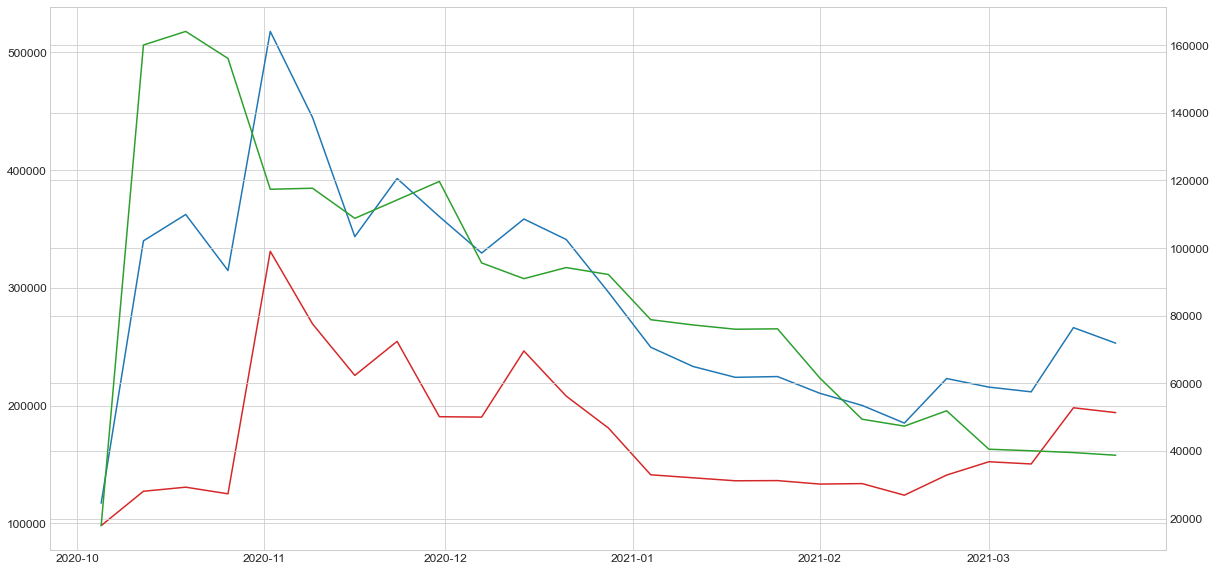

In [96]:
basesale= mc_df[['baseline','Upgrd','Prom_Upgrd','Wk_Start_dt']].groupby('Wk_Start_dt').sum().reset_index()
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

# Specify how our lines should look
ax.plot(basesale.Wk_Start_dt, basesale.baseline, color='tab:red', label='Base Upgrade')

ax.plot(basesale.Wk_Start_dt, basesale.Upgrd, color='tab:blue', label='Total Upgrade')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(basesale.Wk_Start_dt, basesale.Prom_Upgrd, color='tab:green', label='Promo Upgrade')




In [97]:
mc_df['quarter'] = pd.PeriodIndex(mc_df['Mth_End_Dt'], freq='Q')
mc_df.groupby('quarter')['baseline_perc','Prom_perc','tot_mc_perc','Ret_perc','tot_halo_mc_perc'].mean().style.format("{:.2%}")
#mc_df.groupby('quarter')['baseline_perc','Prom_perc','tot_mc_perc'].mean().style.format("{:.2%}")




<ipython-input-97-eacf76f2f405>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mc_df.groupby('quarter')['baseline_perc','Prom_perc','tot_mc_perc','Ret_perc','tot_halo_mc_perc'].mean().style.format("{:.2%}")


,baseline_perc,Prom_perc,tot_mc_perc,Ret_perc,tot_halo_mc_perc
quarter,,,,,
2020Q4,58.35%,32.27%,7.40%,0.17%,1.82%
2021Q1,109.64%,31.13%,11.41%,0.57%,1.43%


In [98]:
mc_df['quarter'] = pd.PeriodIndex(mc_df['Mth_End_Dt'], freq='Q')
#mc_df.groupby('quarter')[list(MMM_var_dict.keys())+['Prom_Upgrd','tot_ret','tot_halo_mc','baseline','Upgrd']].sum().astype('int32').style.format("{:,}")
#mc_df.groupby('quarter')[list(MMM_var_dict.keys())+['Prom_Upgrd','baseline','Upgrd']].sum().astype('int32').style.format("{:,}")

# mc_df.groupby('quarter')[list(MC_var_dict.keys())+['baseline']].sum().reset_index().to_csv("~/Project/MMM1/Data/MMM_decompose_withoutBT.csv")
mc_df.groupby('quarter')[list(MMM_var_dict.keys())+['Prom_Upgrd','tot_ret','tot_halo_mc','baseline','Upgrd']].sum().astype('int32').style.format("{:,}")


,CDL,DM,NP,OD,OH,RD,AFF,CN,EM,MG,PS,SM,TV,Prom_Upgrd,tot_ret,tot_halo_mc,baseline,Upgrd
quarter,,,,,,,,,,,,,,,,,,
2020Q4,"37,695","1,750","15,175","16,735",993,"2,934","1,907","2,218","5,423",3,"167,719","45,526","96,831","1,448,711","8,084","89,802","2,576,872","4,518,388"
2021Q1,"21,374",887,"1,279","12,825",190,382,"1,075",0,0,0,"73,318","20,501","53,494","677,211","15,503","39,814","1,778,105","2,695,967"


In [99]:
mc_df.groupby('quarter')[MMM_var_dict['SM']+MMM_var_dict['PS']+MMM_var_dict['TV']].sum().astype('int32').style.format("{:,}")


,MOB_M_SM_FB_PRD_OTH_IMP,MOB_M_SM_FB_PRD_PRF_IMP,MOB_M_SM_FB_PRD_UPF_IMP,MOB_M_SM_OT_PRD_IMP,MOB_M_SM_ST_PRD_IMP,MOB_M_SM_TW_PRD_IMP,MOB_M_PS_PRD_BND_CLK,MOB_M_PS_PRD_NBD_CLK,MOB_M_PS_PRD_SHP_CLK,MOB_M_TV_AD_PRD_IMP,MOB_M_TV_LN_N_PRD_GM_GRP,MOB_M_TV_LN_N_PRD_HM_GRP
quarter,,,,,,,,,,,,
2020Q4,"5,561","12,073","2,215","13,239","9,555","2,881","20,191","59,798","87,730","72,252","8,349","16,229"
2021Q1,"1,616","6,429","1,383","4,507","5,042","1,522","11,030","21,694","40,593","39,414","4,054","10,024"


In [ ]:
MMM_Mod_v3['quarter'] = pd.PeriodIndex(MMM_Mod_v3['Mth_End_Dt'], freq='Q')

MMM_Mod_v3.groupby('quarter')[list(MMM_var_dict.keys())+['Prom_Upgrd','tot_ret','tot_halo_mc','baseline','Upgrd']].sum().astype('int32').style.format("{:,}")
#mc_df.groupby('quarter')[MMM_var_dict['PS']].sum().astype('int32').style.format("{:,}")



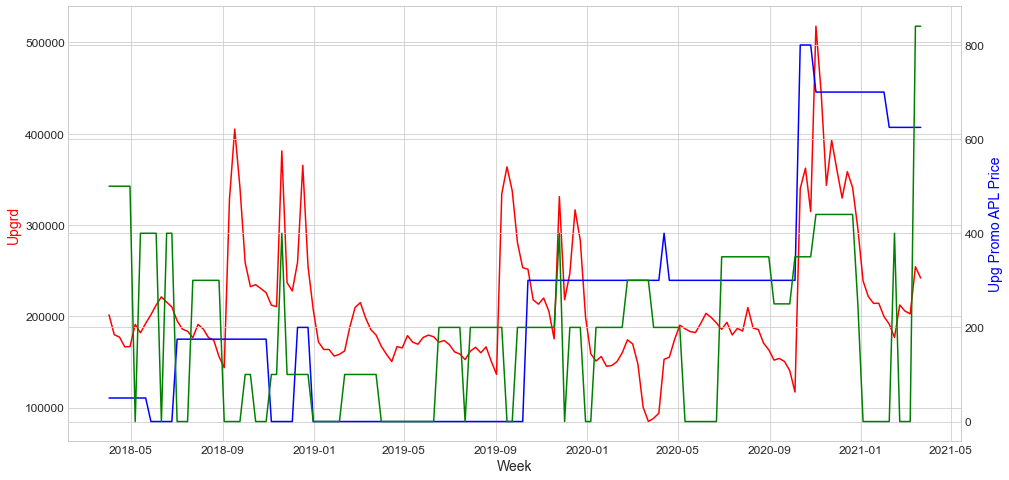

,quarter,Promo_perc,Upgrd
0,2018Q2,0.002246,2517862
1,2018Q3,0.037800,2842819
2,2018Q4,0.023487,3329794
3,2019Q1,0.000000,2359027
4,2019Q2,0.000000,2206445
5,2019Q3,0.000000,2617496
6,2019Q4,0.086374,3212832
7,2020Q1,0.152215,1942825
8,2020Q2,0.153618,2193161
9,2020Q3,0.142091,2301245


In [32]:
df= MMM_Mod.groupby('Wk_Start_dt').agg({'ATT_Upg_APL': 'mean', 'VZ_Upg_APL': 'mean', 'Upgrd': 'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df.Wk_Start_dt, df.Upgrd, color="red")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(df.Wk_Start_dt, df.ATT_Upg_APL,color="blue")
ax2.plot(df.Wk_Start_dt, df.VZ_Upg_APL,color="green")
ax2.set_ylabel("Upg Promo APL Price",color="blue",fontsize=14)



plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')



base_decom_df[['quarter','Promo_perc']].merge(MMM_Mod_df, on =['quarter'])




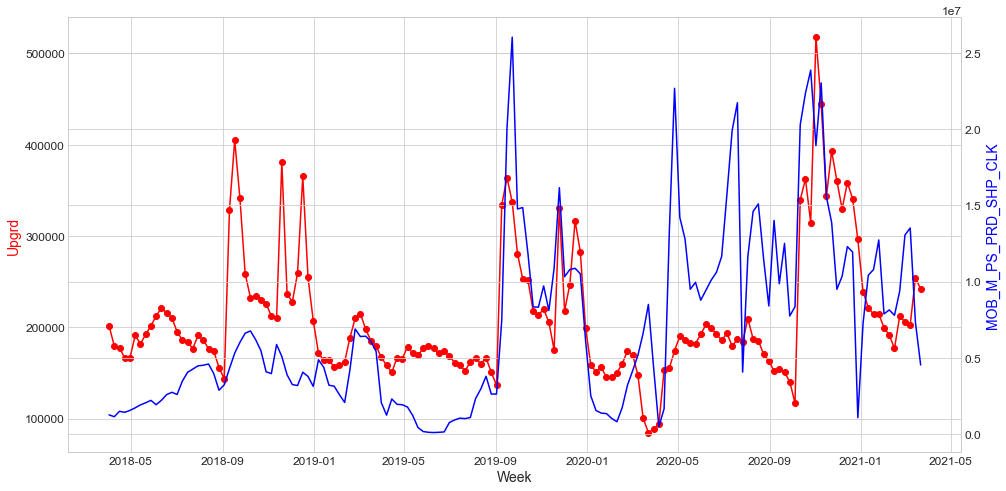

In [33]:

df= MMM_Mod.groupby('Wk_Start_dt').agg({'MOB_M_PS_PRD_SHP_CLK': 'sum', 'Upgrd': 'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df.Wk_Start_dt, df.Upgrd, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(df.Wk_Start_dt, df.MOB_M_PS_PRD_SHP_CLK,color="blue")
ax2.set_ylabel("MOB_M_PS_PRD_SHP_CLK",color="blue",fontsize=14)



plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')



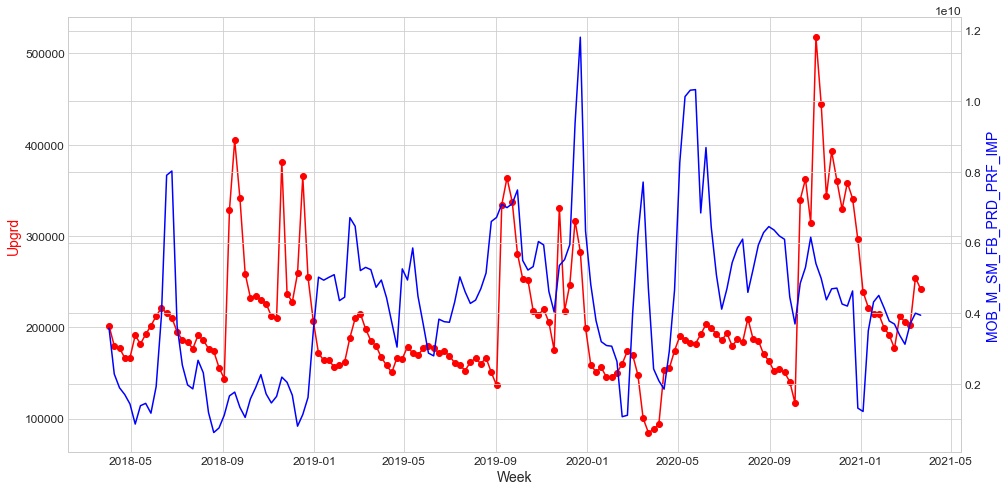

In [34]:
df= MMM_Mod.groupby('Wk_Start_dt').agg({'MOB_M_SM_FB_PRD_PRF_IMP': 'sum', 'Upgrd': 'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df.Wk_Start_dt, df.Upgrd, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(df.Wk_Start_dt, df.MOB_M_SM_FB_PRD_PRF_IMP,color="blue")
ax2.set_ylabel("MOB_M_SM_FB_PRD_PRF_IMP",color="blue",fontsize=14)



plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')


#. TV.1 2019/03/19
#. TV.2 2020/03/19
#. TV.3 >. 2020/03/19



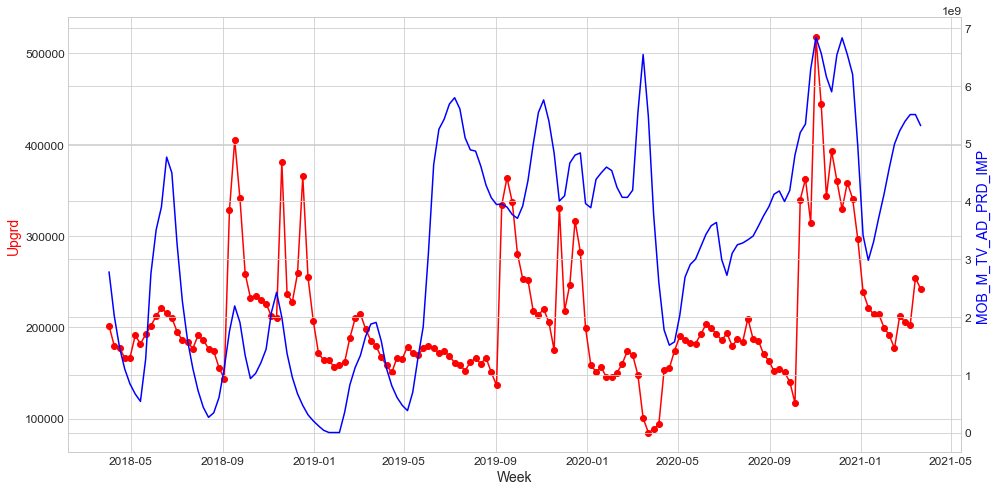

In [35]:

df= MMM_Mod.groupby('Wk_Start_dt').agg({'MOB_M_TV_AD_PRD_IMP': 'sum', 'Upgrd': 'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df.Wk_Start_dt, df.Upgrd, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(df.Wk_Start_dt, df.MOB_M_TV_AD_PRD_IMP,color="blue")
ax2.set_ylabel("MOB_M_TV_AD_PRD_IMP",color="blue",fontsize=14)



plt.show()

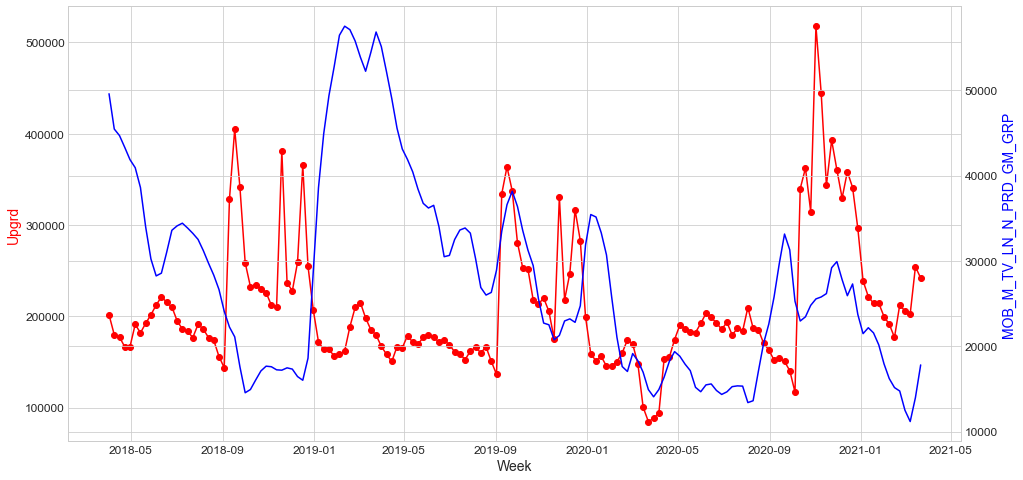

In [36]:

df= MMM_Mod.groupby('Wk_Start_dt').agg({'MOB_M_TV_LN_N_PRD_GM_GRP': 'sum', 'Upgrd': 'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(16, 8))

# make a plot
ax.plot(df.Wk_Start_dt, df.Upgrd, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Week",fontsize=14)
# set y-axis label
ax.set_ylabel("Upgrd",color="red",fontsize=14)
#Next we use twinx() function to create the second axis object “ax2”. Now we use the second axis object “ax2” to make plot of the second y-axis variable and update their labels.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(df.Wk_Start_dt, df.MOB_M_TV_LN_N_PRD_GM_GRP,color="blue")
ax2.set_ylabel("MOB_M_TV_LN_N_PRD_GM_GRP",color="blue",fontsize=14)



plt.show()

In [ ]:
Base_Decom[['Prom_Upgrd_perc','X_GEO','Wk_Start_dt']]


In [ ]:
cols = MMM_Mod_v4.select_dtypes(include=numerics)

cols.columns

In [39]:
mdip_cols=[col for col in Media_Var+Ret_Var+Halo_Media_Var if (col not in Holdout_var) & (col not in Zero_var)]

from sklearn.metrics import r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
fea_var_str ='+'.join(mdip_cols)
model_str ="Upgrd ~ "+ fea_var_str 


md = smf.mixedlm(model_str, MMM_Mod_MeanLog, groups=MMM_Mod_MeanLog["X_GEO"])

mdf = md.fit()

print(mdf.summary())
 #and let's store the rmse

y_predict_log = mdf.fittedvalues*sc_ctrl['Upgrd']*MMM_Mod_SS['line_cnt']
# mdf.fittedvalues*sc_ctrl['Upgrd']*MMM_Mod_SS.line_cnt*sc_ctrl['line_cnt']
y=MMM_Mod_MeanLog.Upgrd*sc_ctrl['Upgrd']*MMM_Mod_MeanLog['line_cnt']
RMSE = sqrt(((y-y_predict)**2).mean())
r2=r2_score(y, y_predict)
print('mape: ', mean_absolute_percentage_error(y, y_predict))


# r2=1. - np.sum(np.abs(y_predict - y) **2) / np.sum(np.abs(y - np.mean(y)) ** 2)
print ('RMSE:',RMSE)
print ('r2:',r2)

                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Upgrd    
No. Observations:        8748          Method:                   REML     
No. Groups:              56            Scale:                    0.0059   
Min. group size:         156           Log-Likelihood:           9478.2241
Max. group size:         168           Converged:                Yes      
Mean group size:         156.2                                            
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       0.531    0.054   9.867 0.000  0.425  0.636
MOB_M_CDL_L_IMP                -0.038    0.004  -8.459 0.000 -0.046 -0.029
MOB_M_DM_AME_L_PRD_CIR         -0.008    0.003  -3.262 0.001 -0.013 -0.003
MOB_M_DM_CIU_L_PRD_CIR          0.004    0.0

NameError: name 'y_predict' is not defined